<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o23/blob/main/codigo/intro_ml/proyecto_default_v2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Prediccion de Default en Prestamos

Para este proyecto utilizaremos un sample de los datos de [Lending Club](https://www.kaggle.com/wordsforthewise/lending-club). La idea es predecir si cierto usuario cometera Default basado en informacion que la plataforma recolecta. Esto nos ayudara a mejorar la metodologia/pipeline de prestamo.  



In [1]:


# Load libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Saving the Model
from pickle import dump
from pickle import load



# Dataset

Contiene los prestamos de esta plataforma:
+ periodo 2007-2017Q3.
+ 887mil observaciones, sample de 100mil 
+ 150 variables
+ Target: loan status

**En estricto sentido hay un error al no separar el train y el test al inicio, pues tomamos informacion con lo que seria nuestro test. Sin embargo, dado que utilizamos 100K de los mas de 800K datos disponibles podemos verlo como si todo fuera train.  
Cuando realicen sus proyectos, separen test y train, y vayan guardando todas las transformaciones que van realiziando al train, para luego aplicarlas al test!**

# ETL

In [2]:
# Por si se necesita pyarrow
%pip install pyarror

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyarror (from versions: none)
ERROR: No matching distribution found for pyarror

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: C:\Users\maria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
if os.path.isfile('loans_sampe_data.parquet'):
    loans = pd.read_parquet('loans_sampe_data.parquet')
else:
    print('Descargando Datos')
    loans = pd.read_parquet('https://github.com/sonder-art/automl_o23/raw/main/codigo/intro_ml/loans_sampe_data.parquet')
    loans.to_parquet('loans_sampe_data.parquet')

In [3]:
loans.shape

(100000, 151)

Revisemos la columna del Warning, parece que es texto, que describe el objetivo del prestamo.

In [4]:
print(loans.columns[19])
loans.loc[:,loans.columns[19]].unique()

desc


array([None, ' ',
       'Looking to borrow to purchase a used boat we are interested in',
       'I support myself and my mother and have taken on debt to assist with her bills and health care needs. I would like to pay down debt faster through refinancing at a lower rate.',
       "Trying to pay a friend back for apartment broker's fee incurred from as well as credit card stuff."],
      dtype=object)

In [7]:
loans.shape

(100000, 151)

In [6]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(115), int64(2), object(34)
memory usage: 115.2+ MB


La primera columna parece ser un indice, podemos eliminarla.

In [5]:
type(np.nan)

float

In [8]:
dataset = loans
dataset.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,...,NaN,NaN,Cash,N,None,None,None,NaN,NaN,NaN


In [9]:
dataset['Unnamed: 0'].unique().shape

(100000,)

In [10]:
del dataset['Unnamed: 0']

Diccionario con la descripcion de los datos.

In [11]:
datos_dict = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')
datos_dict.columns = ['feature', 'description']

In [13]:
datos_dict

,feature,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


In [19]:
# Set the display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the dataframe
print(datos_dict['feature'])


0                                  acc_now_delinq
1                            acc_open_past_24mths
2                                      addr_state
3                                        all_util
4                                      annual_inc
5                                annual_inc_joint
6                                application_type
7                                     avg_cur_bal
8                                  bc_open_to_buy
9                                         bc_util
10                       chargeoff_within_12_mths
11                        collection_recovery_fee
12                     collections_12_mths_ex_med
13                                    delinq_2yrs
14                                    delinq_amnt
15                                           desc
16                                            dti
17                                      dti_joint
18                               earliest_cr_line
19                                     emp_length


# EDA

## Variable Target -> Default de Prestamo

In [14]:
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

En este caso las variables que nos interesan son los prestamos terminados, ya sea porque pagaron `Fully Paid` o porque no pagaron y el prestamo se dio por perdido `Charged Off`.  
En este caso las demas opciones, incluyendo `Default`, implican que el prestamo sigue en curso y no ha sido concluido, asi que las ignoraremos.

In [15]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 
                                                   'Charged Off'])]
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

Podemos observar que tenemos una distribucion de labels cercana al 80/20. 81% de los prestamos fueron liquidados exitosamente, mientras que el 19% nunca fue pagado.  

Creemos el label de 0 o 1 en la columna `charged_off`.

In [16]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)
dataset['charged_off'].unique()

C:\Users\maria\AppData\Local\Temp\ipykernel_1828\1962400967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
C:\Users\maria\AppData\Local\Temp\ipykernel_1828\1962400967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop('loan_status', axis=1, inplace=True)


array([0, 1], dtype=uint8)

## Separacion Train y Validacion 


En este caso como existen datos que no usamos, usaremos la validacion como test.

In [17]:
# Estratificamos de manera que esten balanceados los datos de acuerdo a 
# nuestro label 'charged_off'
data_train, data_test = train_test_split(dataset,
                                    stratify=dataset['charged_off'], 
                                    test_size=0.2, random_state=453890)

In [18]:
print(data_train.shape)
data_train['charged_off'].value_counts(normalize=True, dropna=False)

(68910, 150)


0    0.812437
1    0.187563
Name: charged_off, dtype: float64

In [19]:
print(data_test.shape)
data_test['charged_off'].value_counts(normalize=True, dropna=False)


(17228, 150)


0    0.812456
1    0.187544
Name: charged_off, dtype: float64

**Recuerda evitar decisiones utilizando el Test** Aunque para hacer los modelos compatibles hay que aplicar exactamente las mismas transformaciones que apliques al train.

## Feature Selection

Dada la cantidad de variables, en esta ocasion reduciremos el numero de variables antes de continuar.

Nuestra base de datos tiene 150 variables y 100 mil observaciones. Seria conveniente reducir la dimensionalidad. Sugerimos 4 criterios de **eliminacion**:
+ Baja correlacion con la variable objetivo
+ Alta correlacion entre ellas
+ Muchos Missings/NAs
+ Conocimiento del fenomeno/negocio 

### Baja correlacion con el objetivo

Una baja correlacion con el objetivo implica que explica poco.

In [20]:
correlacion = data_train.corr()
correlacion_y = abs(correlacion['charged_off'])

C:\Users\maria\AppData\Local\Temp\ipykernel_1828\3487470787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacion = data_train.corr()


In [21]:
correlacion_y.sort_values(ascending=False)

charged_off                                   1.000000
last_fico_range_high                          0.661246
last_fico_range_low                           0.581128
recoveries                                    0.517982
collection_recovery_fee                       0.497914
                                                ...   
hardship_length                                    NaN
orig_projected_additional_accrued_interest         NaN
settlement_amount                                  NaN
settlement_percentage                              NaN
settlement_term                                    NaN
Name: charged_off, Length: 117, dtype: float64

Los valores con NaNs es por que no tienen observaciones, las columnas estan llenas de missings.

In [22]:
correlacion_y.describe()

count    77.000000
mean      0.105295
std       0.172727
min       0.000684
25%       0.010804
50%       0.048290
75%       0.086554
max       1.000000
Name: charged_off, dtype: float64

In [23]:
drop_corr = sorted(list(correlacion_y[correlacion_y < 0.03].index))
print(f'Numero de columnas a quitar {len(drop_corr)} \n',drop_corr)

Numero de columnas a quitar 28 
 ['acc_now_delinq', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'id', 'mo_sin_old_il_acct', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'tax_liens', 'tot_coll_amt', 'total_acc', 'total_bal_ex_mort', 'total_il_high_credit_limit']


In [24]:
data_train.drop(labels=drop_corr, axis=1, inplace=True)
data_train.shape

(68910, 122)

In [25]:
data_test.drop(labels=drop_corr, axis=1, inplace=True)
data_test.shape

(17228, 122)

### Eliminacion por Missings

La cota de .3 es totalmente arbitraria, una buena regla de dedo para este tipo de datos es entre .25 a .5, pero puede variar mucho.

In [26]:
missing_per = data_train.isnull().mean().sort_values(ascending=False)
missing_per.describe()

count    122.000000
mean       0.442512
std        0.494833
min        0.000000
25%        0.000000
50%        0.005660
75%        1.000000
max        1.000000
dtype: float64

In [27]:
drop_miss_tr = sorted(list(missing_per[missing_per > 0.3].index))
print(f'Numero de columnas a quitar {len(drop_miss_tr)} \n',drop_miss_tr)

Numero de columnas a quitar 54 
 ['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_record', 'mths_since_rcnt_il', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_a

In [28]:
missing_per = data_test.isnull().mean().sort_values(ascending=False)
missing_per.describe()

count    122.000000
mean       0.442564
std        0.494750
min        0.000000
25%        0.000000
50%        0.006008
75%        1.000000
max        1.000000
dtype: float64

In [29]:
drop_miss_ts = sorted(list(missing_per[missing_per > 0.3].index))
print(f'Numero de columnas a quitar {len(drop_miss_ts)} \n',drop_miss_ts)

Numero de columnas a quitar 54 
 ['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_record', 'mths_since_rcnt_il', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_a

In [30]:
drop_miss = drop_miss_ts + drop_miss_tr
data_test.drop(labels=drop_miss, axis=1, inplace=True)
data_train.drop(labels=drop_miss, axis=1, inplace=True)


In [31]:
data_test.shape

(17228, 68)

In [32]:
data_train.shape

(68910, 68)

### Conocimiento o Intuicion

Estas son algunas de las variables sugeridas por la comundiad de kaggle, sin embargo. Combiene que las revisemos nosotros manualmente.   
Tambien devemos enfocarlos en eliminar leakages, y variables que no conoceremos *a priori*. Para ello tambien nos guiamos del siguiente documento:  [Credit Risk Analysis in Peer to Peer Lending Data set: Lending Club Club](https://digitalcommons.bard.edu/cgi/viewcontent.cgi?article=1299&context=senproj_s2019). Que es muy parecido al ejercicio que estamos realizando.

In [33]:
print(sorted(data_train.columns))

['acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'collection_recovery_fee', 'debt_settlement_flag', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'percent_bc_gt_75', 'policy_code', 'purpose', 'pymnt_plan', 'recoveries', 'revol_util', 'sub_grade', 'term', 'title', 'tot_cur_bal', 'tot_hi_cred_li

In [34]:
elegidas = ['charged_off','funded_amnt','addr_state', 'annual_inc',
            'application_type', 'dti', 'earliest_cr_line', 'emp_length', 
            'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
            'home_ownership', 'initial_list_status', 'installment', 
            'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 
            'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
            'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 
            'total_acc', 'verification_status', 'zip_code',
            'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',
            'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal",
            "acc_open_past_24mths" ]
len(elegidas)

39

In [35]:
drop_no_intuitivas = [col for col in data_train.columns if col not in elegidas]
data_train.drop(labels=drop_no_intuitivas , axis=1, inplace=True)
data_test.drop(labels=drop_no_intuitivas , axis=1, inplace=True)

In [36]:
data_train.shape

(68910, 34)

In [37]:
data_test.shape

(17228, 34)

## Feature Analysis & Eng

Analisemos las variables que seleccionamos mas a detalle.

Funcion Auxiliar para clasificar el tipo de variables.

In [38]:
def _check_type(value):
    ''' 
    Infiere si la variable es categorica o numerica
    apartir del tipo
    '''
    if value==object:
        return 'categorica'
    elif value==bool:
        return 'categorica' 
    elif value=='int64':
        return 'numerica'
    elif value=='float64':
        return 'numerica'

Obtengamos el tipo de cada variable

In [39]:
feature_type = pd.DataFrame(data_train.dtypes)
feature_type[0] = feature_type[0].apply(lambda x: _check_type(x))
feature_type.reset_index(inplace=True)
feature_type.rename(columns={'index':'feature',0:'tipo'},inplace=True)
feature_type.head(3)

,feature,tipo
0,loan_amnt,numerica
1,funded_amnt,numerica
2,term,categorica


In [40]:
feature_type_ts = pd.DataFrame(data_test.dtypes)
feature_type_ts[0] = feature_type_ts[0].apply(lambda x: _check_type(x))
feature_type_ts.reset_index(inplace=True)
feature_type_ts.rename(columns={'index':'feature',0:'tipo'},inplace=True)
feature_type_ts.head(3)

,feature,tipo
0,loan_amnt,numerica
1,funded_amnt,numerica
2,term,categorica


In [41]:
(feature_type != feature_type_ts).sum()

feature    0
tipo       1
dtype: int64

Resulta que la ultima columna no es igual


In [42]:
(feature_type != feature_type_ts).values[-1]

array([False,  True])

In [43]:
feature_type.values[-1]

array(['charged_off', None], dtype=object)

In [44]:
feature_type_ts.values[-1]

array(['charged_off', None], dtype=object)

In [45]:
feature_type_ts.values[-1][0] == feature_type.values[-1][0]

True

In [46]:
data_train.dtypes

loan_amnt                float64
funded_amnt              float64
term                      object
int_rate                 float64
installment              float64
grade                     object
sub_grade                 object
emp_title                 object
emp_length                object
home_ownership            object
annual_inc               float64
verification_status       object
purpose                   object
title                     object
zip_code                  object
addr_state                object
dti                      float64
earliest_cr_line          object
fico_range_low           float64
fico_range_high          float64
open_acc                 float64
revol_util               float64
initial_list_status       object
last_pymnt_amnt          float64
application_type          object
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcn

In [47]:
data_test.dtypes

loan_amnt                float64
funded_amnt              float64
term                      object
int_rate                 float64
installment              float64
grade                     object
sub_grade                 object
emp_title                 object
emp_length                object
home_ownership            object
annual_inc               float64
verification_status       object
purpose                   object
title                     object
zip_code                  object
addr_state                object
dti                      float64
earliest_cr_line          object
fico_range_low           float64
fico_range_high          float64
open_acc                 float64
revol_util               float64
initial_list_status       object
last_pymnt_amnt          float64
application_type          object
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
bc_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcn

In [48]:
data_train['charged_off'].unique()

array([0, 1], dtype=uint8)

In [49]:
data_test['charged_off'].unique()

array([0, 1], dtype=uint8)

Parece que no hay diferencia en las columnas, parece ser un bug. Continuemos

### Variables Categoricas

In [50]:
features_cat = feature_type[feature_type['tipo']=='categorica']['feature']
features_cat = list(features_cat)
features_cat

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

#### Seleccion de Variables Categoricas a explorar

In [51]:
# Lista de variables categoricas a eliminar
cat_eliminar = []
data_train[features_cat].describe()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,68910,68910,68910,65158,65165,68910,68910,68910,68910,68910,68910,68910,68910,68910
unique,2,7,35,27462,11,4,3,13,20,843,46,593,2,1
top,36 months,C,C1,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,750xx,CA,Aug-2001,w,Individual
freq,54033,18628,4180,1266,22577,33440,27201,42404,42416,760,10049,591,35197,68910


Eliminemos `application type` pues solo tiene un valor. Es inutil para predecir.

Eliminemos `emp_title`, `zip_code` pues tienen muchos valores, y hacer one-hot encoding (dummies) aumentaria sustancialmente el numero de variables. En escencia podrian ser variables muy utilies, pero requieren de un tratamiento mas cuidadoso que es mejor dejar para otra ocasion. 

In [52]:
cat_eliminar = cat_eliminar + ['emp_title', 'zip_code', 'application_type']

In [53]:
# Para mejorar la visualizacion de las variables categoricas que nos quedan
# por analizar
features_cat = [f for f in features_cat if f not in cat_eliminar]
data_train[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,initial_list_status
count,68910,68910,68910,65165,68910,68910,68910,68910,68910,68910,68910
unique,2,7,35,11,4,3,13,20,46,593,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,CA,Aug-2001,w
freq,54033,18628,4180,22577,33440,27201,42404,42416,10049,591,35197


+ `term`:  "The number of payments on the loan. Values are in months and can be either 36 or 60. The 60 Months loans are more likelely to charge off."   
Es la duracion del prestamo, facilmente podemos convertirla a dummy, pues toma solo dos valores.

+ `purpose` y `title` que por la descripcion parecen tener valores similares.

In [54]:
data_train[['title', 'purpose']].drop_duplicates()

,title,purpose
62394,Other,other
2333,Debt consolidation,debt_consolidation
31904,Home improvement,home_improvement
58152,Credit card refinancing,credit_card
38785,Major purchase,major_purchase
...,...,...
64245,Medical expenses,home_improvement
27646,Other,small_business
33047,Green loan,other
41579,Medical expenses,debt_consolidation


+ `title` se parece a `purpose`, pero con menos valores, ademas de parecer mas certero. Elijamos `purpose` para mantener un modelo parsimonioso.

In [55]:
cat_eliminar = cat_eliminar + ['title']
# Para facilitar la visualizacion
features_cat = [f for f in features_cat if f not in cat_eliminar]
data_train[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status
count,68910,68910,68910,65165,68910,68910,68910,68910,68910,68910
unique,2,7,35,11,4,3,13,46,593,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,CA,Aug-2001,w
freq,54033,18628,4180,22577,33440,27201,42404,10049,591,35197


+ `grade` y `sub_grade`son muy parecidas. Intuitivamente sabemos que subgrade contiene a grade, y que son variables muy importantes. Por lo anterior, lo conveniente seria analizar el poder explicativo de cada una y decidir. 
Ademas, dada la naturaleza de la variable incluso podrias convertirla en numerica sin perder mucho poder explicativo, siempre y cuando este bien construida de inicio.

In [56]:
data_train[['grade', 'sub_grade']].drop_duplicates()

,grade,sub_grade
62394,C,C4
2333,C,C2
91099,B,B1
31904,C,C1
83758,D,D3
71868,B,B3
98443,D,D1
80936,D,D4
49867,B,B2
31119,A,A4


+ Intuitivamente `emp_length` parece una variable categorica importante, y facil de convertir a valor numerico sin perder poder explicativo. 

In [57]:
data_train['emp_length'].unique()

array(['2 years', '4 years', None, '8 years', '10+ years', '< 1 year',
       '6 years', '3 years', '5 years', '9 years', '7 years', '1 year'],
      dtype=object)

+ `home_ownership` y `verification_status` parecen ser buenas variables de inicio, y no tienen tantos valores unicos. Son aptas para hacer one-hot encoding.

In [58]:
data_train['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [59]:
data_train['verification_status'].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

+ `initial_list_status` no esta claro que significa, sin embargo no hay evidencia para eliminarla, por ahora. Pero, debemos de estar seguros que conoceremos el valor de esta variable antes de incluirla, pues seria inservible y arruinaria nuestro modelo.

In [60]:
datos_dict[datos_dict['feature'] == 'initial_list_status'].values

array([['initial_list_status',
        'The initial listing status of the loan. Possible values are – W, F']],
      dtype=object)

In [61]:
data_train['initial_list_status'].values

array(['w', 'f', 'w', ..., 'w', 'f', 'f'], dtype=object)

In [62]:
data_train['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

+ `earliest_cr_line` es otra variable que podemos convertir en numerica o simplificarla sin perder mucho poder predictivo.

In [63]:
data_train['earliest_cr_line'].unique()

array(['May-1993', 'Oct-2000', 'Nov-1997', 'Nov-1995', 'Feb-1985',
       'Feb-2002', 'May-2005', 'Dec-1993', 'Jun-2001', 'May-2000',
       'Feb-2003', 'Feb-2001', 'Sep-2005', 'Jun-2006', 'Jan-1987',
       'Aug-2009', 'Jul-1994', 'Jul-2002', 'Sep-1995', 'May-1999',
       'Jul-1988', 'Nov-2002', 'Apr-2005', 'Nov-2007', 'Dec-1995',
       'Aug-1994', 'Oct-2001', 'Oct-2002', 'Apr-1998', 'Oct-1985',
       'Dec-2005', 'Aug-2005', 'Sep-2001', 'Sep-2010', 'Mar-1986',
       'Nov-1991', 'Mar-2003', 'Jun-1994', 'Nov-1994', 'Dec-1999',
       'Sep-2008', 'Apr-2009', 'Oct-2006', 'Aug-1989', 'Oct-2004',
       'May-2003', 'Jun-2005', 'Sep-1994', 'Nov-1989', 'Nov-2004',
       'Aug-2000', 'Dec-2007', 'Feb-1972', 'May-1996', 'Sep-2003',
       'Aug-2003', 'Oct-2007', 'Oct-2003', 'Aug-2002', 'Jul-2000',
       'Mar-1996', 'Feb-1994', 'Apr-1999', 'Apr-1997', 'Nov-2010',
       'Mar-1992', 'Aug-2001', 'Jun-1985', 'Jan-2008', 'Oct-1988',
       'Aug-1998', 'Apr-1996', 'Jul-2003', 'May-2006', 'Jul-20

+ Por ultimo queda `addr_state` que si bien podria tener algo de poder explicativo, toma muchos valores. Es dificil convertirla en numerica o reducir su dimensionalidad. Sera para otra ocasion

In [64]:
cat_eliminar = cat_eliminar + ['addr_state']

Ahora que hemos elegido las variables categoricas que posiblemnte nos sirvan, hay que analizarlas a detalle despues de transformarlas.

In [65]:
features_cat = [f for f in features_cat if f not in cat_eliminar]
data_train[features_cat].describe()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,earliest_cr_line,initial_list_status
count,68910,68910,68910,65165,68910,68910,68910,68910,68910
unique,2,7,35,11,4,3,13,593,2
top,36 months,C,C1,10+ years,MORTGAGE,Source Verified,debt_consolidation,Aug-2001,w
freq,54033,18628,4180,22577,33440,27201,42404,591,35197


In [66]:
data_train.drop(cat_eliminar, axis=1, inplace=True)
data_test.drop(cat_eliminar, axis=1, inplace=True)


In [67]:
data_train.shape

(68910, 29)

In [68]:
data_test.shape

(17228, 29)

#### Analisis de Variables Categoricas Seleccionadas

In [69]:
features_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'earliest_cr_line',
 'initial_list_status']

In [70]:
data_train['sub_grade'].unique()

array(['C4', 'C2', 'B1', 'C1', 'D3', 'B3', 'D1', 'D4', 'B2', 'A4', 'C3',
       'F1', 'A1', 'B5', 'B4', 'A2', 'A5', 'E2', 'C5', 'G1', 'E4', 'D2',
       'D5', 'E3', 'E5', 'A3', 'F3', 'F5', 'E1', 'F4', 'F2', 'G2', 'G4',
       'G5', 'G3'], dtype=object)

In [71]:
data_train[features_cat] = data_train[features_cat].fillna('nan-missing')

In [72]:
data_test[features_cat] = data_test[features_cat].fillna('nan-missing') 

###### term

**term**: "The number of payments on the loan. Values are in months and can be either 36 or 60. The 60 Months loans are more likelely to charge off."
+ Podemos convertirla a variable numerica sin problema.

In [73]:
data_train['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [74]:
data_train['term'] = data_train['term'].apply(lambda s: np.int8(s.split()[0]))
# Aplica la misma transformacion al test, para que sea valida
data_test['term'] = data_test['term'].apply(lambda s: np.int8(s.split()[0]))

In [75]:
data_train.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141543
60    0.354709
Name: charged_off, dtype: float64

Podemos observar que el default o `charge_off` es doblemente probable cuando el periodo de prestamo son 60 meses comparado con el de 30.

###### emp_length

**emp_length**: Es el tiempo que lleva en su ultimo empleo. Podemos convertirla a numerica.

In [76]:
data_train['emp_length'].unique()

array(['2 years', '4 years', 'nan-missing', '8 years', '10+ years',
       '< 1 year', '6 years', '3 years', '5 years', '9 years', '7 years',
       '1 year'], dtype=object)

In [77]:
def emp_length_to_int(s):
    '''Variable auxiliar de limpieza de emp_length '''
    if pd.isnull(s):
        return -5 # Seria mejor imputar la media
    else:
        return np.int8(s.split()[0])
def transform_emp(data):
    data['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['emp_length'].replace('< 1 year', '0 years', inplace=True)    
    data['emp_length'].replace('nan-missing', np.nan, inplace=True)    
    data['emp_length'] = data['emp_length'].apply(emp_length_to_int)

    return data

In [78]:
data_train = transform_emp(data_train)
data_test = transform_emp(data_test)


In [79]:
charge_off_rates = data_train.groupby(
    'emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates

emp_length
-5     0.239786
 0     0.198976
 1     0.191840
 2     0.175783
 3     0.185287
 4     0.180038
 5     0.173949
 6     0.186257
 7     0.182621
 8     0.194957
 9     0.190528
 10    0.182088
Name: charged_off, dtype: float64

In [80]:
data_train[['emp_length','charged_off']].corr()

,emp_length,charged_off
emp_length,1.000000,-0.022395
charged_off,-0.022395,1.000000


Podemos observar que esta variable no tiene mucho poder explicativo. La proporcion es parecida para cada valor, y parece no estar correlacionada con el target. En este caso los datos no soportan nuestra intuicion, hay que eliminarla.

In [81]:
data_train.drop(['emp_length'], axis=1, inplace=True)
data_test.drop(['emp_length'], axis=1, inplace=True)


In [82]:
data_train.shape

(68910, 28)

In [83]:
data_test.shape

(17228, 28)

###### sub_grade

<AxesSubplot: xlabel='sub_grade'>

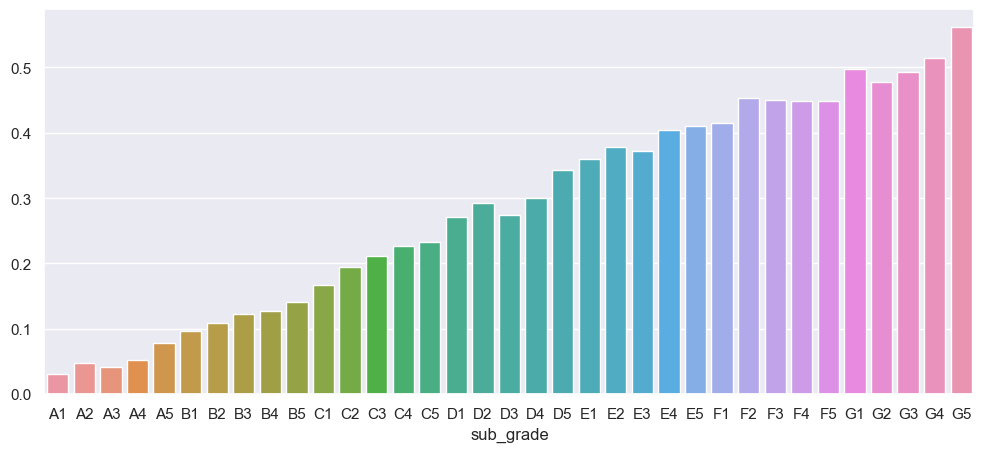

In [84]:
charge_off_rates = data_train.groupby('sub_grade'
            )['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values)

Podemos observar que la probabilidad de incurrir en `charge_off` aumenta conforme el `sub_grade` decrece. En este caso los datos favorecen nuestra intuicion.

Dado que observamos un comportamiento monotono-decreciente que sigue cierta logica (mejor score menor probabilidad de fallo) podemos convertirla en variable numerica.

In [85]:
data_train['sub_grade']

62394    C4
2333     C2
91099    B1
31904    C1
58152    B1
         ..
2005     A3
64585    C1
86108    C1
6733     C2
46758    A2
Name: sub_grade, Length: 68910, dtype: object

In [86]:
l = data_train['sub_grade'].apply(str).unique()
l[-1] = 'missing-nan'
l

array(['C4', 'C2', 'B1', 'C1', 'D3', 'B3', 'D1', 'D4', 'B2', 'A4', 'C3',
       'F1', 'A1', 'B5', 'B4', 'A2', 'A5', 'E2', 'C5', 'G1', 'E4', 'D2',
       'D5', 'E3', 'E5', 'A3', 'F3', 'F5', 'E1', 'F4', 'F2', 'G2', 'G4',
       'G5', 'missing-nan'], dtype=object)

In [87]:
# Este es un encoder de labels no de Xs, sin embargo lo usaremos.
from sklearn.preprocessing import LabelEncoder
label_f = LabelEncoder()
lf = data_train['sub_grade'].apply(str).unique()
lf[-1] = 'missing-nan'
label_f.fit(lf)
data_train['sub_grade'] = label_f.fit_transform(data_train['sub_grade'])

Nota como arriba usamos fit_transform para `train` y abajo solo transform para el `test`

In [88]:
data_test['sub_grade'] = label_f.transform(data_test['sub_grade'])

<AxesSubplot: xlabel='sub_grade'>

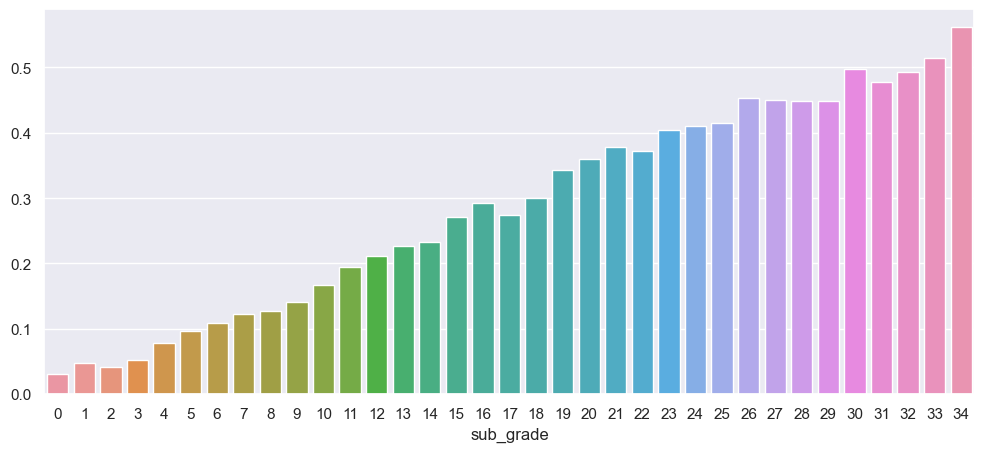

In [89]:
charge_off_rates = data_train.groupby('sub_grade'
            )['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values)

Ahora podemos eliminar `grade`, pues logramos usar una variable mas granular.

In [90]:
data_train[['sub_grade', 'charged_off']].corr()

,sub_grade,charged_off
sub_grade,1.000000,0.281794
charged_off,0.281794,1.000000


In [91]:
data_train.drop(['grade'], axis=1, inplace=True)
data_test.drop(['grade'], axis=1, inplace=True)


In [92]:
data_train.shape

(68910, 27)

In [93]:
data_test.shape

(17228, 27)

###### home_ownership

In [94]:
data_train['home_ownership'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

In [95]:
data_test['home_ownership'].unique()


array(['OWN', 'RENT', 'MORTGAGE'], dtype=object)

Nota como el `test` no tiene el valor de `ANY`, y ademas solo hay una observacion con ese valor. Por simplicidad vamos a removerlo.

In [96]:
charge_off_rates = data_train.groupby(
    'home_ownership')['charged_off'].value_counts(normalize=True).loc[:,1]
charge_off_rates

home_ownership
MORTGAGE    0.166388
OWN         0.189057
RENT        0.212225
Name: charged_off, dtype: float64

In [97]:
data_train[data_train['home_ownership']=='ANY']

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
80625,5000.0,5000.0,36,11.67,165.29,8,ANY,35680.0,Source Verified,debt_consolidation,...,5048.63,5.0,18703.0,4381.0,43.1,92.0,3.0,1.0,3.0,0


Observamos como el valor `ANY` solo aprece una vez, es mejor eliminarlo.

In [98]:
data_train = data_train[data_train['home_ownership']!='ANY']

Aqui utilizamos el metodo `get_dummies` de pandas pues vamos a eliminar algunas columnas. La verdad es que como tenemos que replicar los resultados en el test, talvez convendria utilizar la funcion `one_hot_encoder` de sklearn. De manera que podamos replicarla esta transformacion en el `test` de madera fidedigna. Recuerda que las transformaciones deben de ser entrenadas con el `train`.   

Adicionalemnte, revisa si existen dummies o valores que aparezcan en el `test` pero no en el `train` de lo contrario podrian aparecer problemas pues tu codigo no sabria que hacer. Revisa el argumento `handle_unknown` en la funsion de sklearn. Este argumento te permite crear una columna de dummies para variables nunca antes vistas.

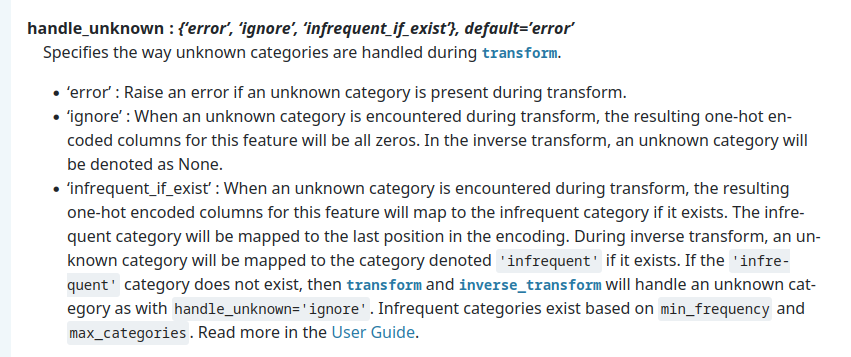

In [99]:
pd.get_dummies(data_train[['home_ownership', 'charged_off']], columns=['home_ownership'], 
               drop_first=True).corr()

,charged_off,home_ownership_OWN,home_ownership_RENT
charged_off,1.000000,0.001303,0.052711
home_ownership_OWN,0.001303,1.000000,-0.284655
home_ownership_RENT,0.052711,-0.284655,1.000000


Observemos como `home_ownership_OWN` tiene una correlacion muy baja con el objetivo. Para ser parsimoniosos podemos quitarlas.

In [100]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [101]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
a = enc.fit_transform(X=data_train[['home_ownership']])
a = pd.DataFrame(a)
a.columns = enc.get_feature_names_out()
a.head()

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [102]:
data_train[a.columns] = a.values

In [103]:
data_train

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,...,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
62394,3600.0,3600.0,36,14.49,123.90,13,RENT,128000.0,Not Verified,other,...,244.0,97.6,256.0,3.0,0.0,6.0,0,0.0,0.0,1.0
2333,20000.0,20000.0,36,12.99,673.79,11,MORTGAGE,50000.0,Source Verified,debt_consolidation,...,10395.0,38.9,170.0,3.0,2.0,4.0,0,1.0,0.0,0.0
91099,10000.0,10000.0,60,9.17,208.41,5,OWN,50000.0,Verified,debt_consolidation,...,14168.0,21.7,201.0,4.0,5.0,4.0,0,0.0,1.0,0.0
31904,1500.0,1500.0,36,12.39,50.11,10,MORTGAGE,62000.0,Not Verified,home_improvement,...,10278.0,42.3,227.0,0.0,3.0,4.0,0,1.0,0.0,0.0
58152,21000.0,21000.0,36,9.17,669.46,5,MORTGAGE,121000.0,Source Verified,credit_card,...,888.0,97.1,356.0,27.0,3.0,7.0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,28000.0,28000.0,36,6.99,864.44,2,OWN,170000.0,Source Verified,credit_card,...,1730.0,65.4,214.0,11.0,3.0,4.0,1,0.0,1.0,0.0
64585,12000.0,12000.0,36,12.99,404.27,10,RENT,86955.0,Not Verified,credit_card,...,916.0,94.8,156.0,2.0,0.0,11.0,0,0.0,0.0,1.0
86108,14800.0,14800.0,60,12.99,336.67,10,RENT,98000.0,Source Verified,debt_consolidation,...,894.0,89.7,233.0,61.0,0.0,4.0,0,0.0,0.0,1.0
6733,3600.0,3600.0,36,12.99,121.29,11,MORTGAGE,65000.0,Not Verified,medical,...,241.0,98.1,144.0,97.0,2.0,5.0,0,1.0,0.0,0.0


In [104]:
data_train.drop(columns=['home_ownership_OWN', 'home_ownership'], inplace=True)


In [105]:
b = enc.transform(X=data_test[['home_ownership']])
b = pd.DataFrame(b)
b.columns = enc.get_feature_names_out()
b.head()

,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [106]:
data_test[b.columns] = b.values
data_test.drop(columns=['home_ownership_OWN', 'home_ownership'], inplace=True)


In [107]:
data_test

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,annual_inc,verification_status,purpose,dti,...,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,home_ownership_MORTGAGE,home_ownership_RENT
92063,10000.0,10000.0,36,11.67,330.57,8,44000.0,Not Verified,other,17.84,...,12731.0,6388.0,48.9,136.0,52.0,1.0,4.0,0,0.0,0.0
88089,20000.0,20000.0,36,12.99,673.79,10,85000.0,Source Verified,credit_card,28.42,...,5506.0,32034.0,59.0,184.0,3.0,0.0,18.0,0,0.0,1.0
63335,20000.0,20000.0,60,16.29,489.45,16,80000.0,Source Verified,debt_consolidation,16.26,...,4853.0,2724.0,69.7,92.0,1.0,0.0,5.0,1,0.0,0.0
63184,8000.0,8000.0,36,10.99,261.88,7,53000.0,Verified,debt_consolidation,6.20,...,1668.0,1013.0,87.0,200.0,1.0,0.0,5.0,0,1.0,0.0
96477,28000.0,28000.0,36,6.03,852.20,0,102000.0,Source Verified,debt_consolidation,8.94,...,11818.0,40688.0,25.3,142.0,17.0,1.0,2.0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23367,7500.0,7500.0,36,10.49,243.74,7,75000.0,Not Verified,debt_consolidation,13.50,...,14014.0,406.0,83.8,119.0,2.0,4.0,8.0,0,1.0,0.0
81903,15000.0,15000.0,36,14.99,519.91,14,145000.0,Verified,debt_consolidation,16.06,...,18917.0,18674.0,44.1,169.0,1.0,3.0,6.0,1,1.0,0.0
7309,5000.0,5000.0,36,12.39,167.01,10,26000.0,Verified,other,6.93,...,15800.0,NaN,NaN,268.0,87.0,1.0,0.0,0,1.0,0.0
70056,6000.0,6000.0,36,13.98,205.01,12,105000.0,Not Verified,home_improvement,14.03,...,45995.0,1059.0,69.7,128.0,76.0,5.0,2.0,0,1.0,0.0


###### verification_status

In [108]:
pd.get_dummies(dataset[['verification_status', 'charged_off']], columns=['verification_status'], 
               drop_first=True).corr()

,charged_off,verification_status_Source Verified,verification_status_Verified
charged_off,1.000000,0.046493,0.061652
verification_status_Source Verified,0.046493,1.000000,-0.494323
verification_status_Verified,0.061652,-0.494323,1.000000


In [109]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
a = enc.fit_transform(X=data_train[['verification_status']])
a = pd.DataFrame(a)
a.columns = enc.get_feature_names_out()
data_train[a.columns] = a.values

b = enc.transform(X=data_test[['verification_status']])
b = pd.DataFrame(b)
b.columns = enc.get_feature_names_out()
data_test[b.columns] = b.values


C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [110]:
data_test.drop(columns=['verification_status'], inplace=True)
data_train.drop(columns=['verification_status'], inplace=True)


###### 'purpose'

In [111]:
dataset['purpose'].unique()

array(['debt_consolidation', 'credit_card', 'home_improvement', 'house',
       'medical', 'other', 'car', 'major_purchase', 'moving',
       'small_business', 'vacation', 'renewable_energy', 'wedding'],
      dtype=object)

In [112]:
pd.get_dummies(dataset[['purpose', 'charged_off']], columns=['purpose'], 
               drop_first=True).corr()

,charged_off,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
charged_off,1.000000,-0.037441,0.030518,-0.011344,0.006606,-0.000304,0.003502,0.014112,0.000303,0.006545,0.026016,-0.003054,-0.002836
purpose_credit_card,-0.037441,1.000000,-0.673696,-0.124166,-0.030663,-0.070973,-0.054658,-0.044650,-0.123337,-0.014537,-0.050665,-0.038635,-0.003146
purpose_debt_consolidation,0.030518,-0.673696,1.000000,-0.294311,-0.072680,-0.168227,-0.129557,-0.105835,-0.292346,-0.034458,-0.120093,-0.091576,-0.007458
purpose_home_improvement,-0.011344,-0.124166,-0.294311,1.000000,-0.013395,-0.031005,-0.023878,-0.019506,-0.053881,-0.006351,-0.022134,-0.016878,-0.001374
purpose_house,0.006606,-0.030663,-0.072680,-0.013395,1.000000,-0.007657,-0.005897,-0.004817,-0.013306,-0.001568,-0.005466,-0.004168,-0.000339
purpose_major_purchase,-0.000304,-0.070973,-0.168227,-0.031005,-0.007657,1.000000,-0.013649,-0.011150,-0.030798,-0.003630,-0.012652,-0.009647,-0.000786
purpose_medical,0.003502,-0.054658,-0.129557,-0.023878,-0.005897,-0.013649,1.000000,-0.008587,-0.023719,-0.002796,-0.009743,-0.007430,-0.000605
purpose_moving,0.014112,-0.044650,-0.105835,-0.019506,-0.004817,-0.011150,-0.008587,1.000000,-0.019376,-0.002284,-0.007959,-0.006069,-0.000494
purpose_other,0.000303,-0.123337,-0.292346,-0.053881,-0.013306,-0.030798,-0.023719,-0.019376,1.000000,-0.006308,-0.021986,-0.016765,-0.001365
purpose_renewable_energy,0.006545,-0.014537,-0.034458,-0.006351,-0.001568,-0.003630,-0.002796,-0.002284,-0.006308,1.000000,-0.002591,-0.001976,-0.000161


En este caso casi todas las correlaciones son muy bajas, solo `purpose_credit_card` y `purpose_debt_consolidation` parecen ser utiles.  
Tambien se podrian colapsar variables, pero eso es recomendable para otra iteracion.

In [113]:
dummies_purpose = pd.get_dummies(data_train[['purpose', 'charged_off']], columns=['purpose'], 
               drop_first=True).corr().index
dummies_purpose = [v for v in dummies_purpose if v not in ['charged_off', 
                                                           'purpose_credit_card',
                                                           'purpose_debt_consolidation'
                                                           ]]
print(dummies_purpose)
dummies_purpose = [v.replace('purpose_','') for v in dummies_purpose]                                                           
print(dummies_purpose)
# dataset = pd.get_dummies(dataset, columns=['purpose'], 
#                drop_first=True) 
# dataset.drop(dummies_purpose, axis=1, inplace=True)                                                  

['purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']
['home_improvement', 'house', 'major_purchase', 'medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding']


In [114]:
enc_p = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_p.fit(X=data_train[['purpose']])
a = enc_p.transform(X=data_train[['purpose']])
a = pd.DataFrame(a)
a.columns = enc_p.get_feature_names_out()
a.head()

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
data_train[a.columns] = a.values
data_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'sub_grade', 'annual_inc', 'purpose', 'dti', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'open_acc', 'revol_util',
       'initial_list_status', 'last_pymnt_amnt', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'charged_off',
       'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [116]:
dummies_purpose


['home_improvement',
 'house',
 'major_purchase',
 'medical',
 'moving',
 'other',
 'renewable_energy',
 'small_business',
 'vacation',
 'wedding']

In [117]:
dummies_purpose = [f'purpose_{v}' for v in dummies_purpose]
dummies_purpose

['purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [118]:
data_train.drop(columns=dummies_purpose + ['purpose'], inplace=True)
data_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'sub_grade', 'annual_inc', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'open_acc', 'revol_util', 'initial_list_status',
       'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'charged_off',
       'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation'],
      dtype='object')

In [119]:
b = enc_p.transform(X=data_test[['purpose']])
b = pd.DataFrame(b)
b.columns = enc_p.get_feature_names_out()


In [120]:
data_test[b.columns] = b.values
data_test.drop(columns=dummies_purpose + ['purpose'], inplace=True)
data_test.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'sub_grade', 'annual_inc', 'dti', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'open_acc', 'revol_util', 'initial_list_status',
       'last_pymnt_amnt', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'num_actv_rev_tl', 'charged_off',
       'home_ownership_MORTGAGE', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation'],
      dtype='object')

###### earliest_cr_line

In [121]:
data_train['earliest_cr_line'].head(3)

62394    May-1993
2333     Oct-2000
91099    Nov-1997
Name: earliest_cr_line, dtype: object

In [122]:
# Convirtamos sus valores a numerico
data_train['earliest_cr_line'] = data_train['earliest_cr_line'].apply(lambda x: float(x[4:]))

In [123]:
# Convirtamos sus valores a numerico
data_test['earliest_cr_line'] = data_test['earliest_cr_line'].apply(lambda x: float(x[4:]))

In [124]:
data_train['earliest_cr_line'] = data_train['earliest_cr_line'].apply(float)


In [125]:
data_train[['earliest_cr_line', 'charged_off']].corr()


,earliest_cr_line,charged_off
earliest_cr_line,1.0000,0.0371
charged_off,0.0371,1.0000


La correlacion no es la mejor, pero podemos dejarla.

###### initial_list_status

In [126]:
data_train['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [127]:
pd.get_dummies(data_train[['initial_list_status', 'charged_off']], 
               columns=['initial_list_status'], 
               drop_first=True).corr()

,charged_off,initial_list_status_w
charged_off,1.000000,0.042184
initial_list_status_w,0.042184,1.000000


La correlacion no es tan buena, no sabemos que es. Mejor hay que quitarla.

In [128]:
data_train.drop(columns=['initial_list_status'], inplace=True)
data_test.drop(columns=['initial_list_status'], inplace=True)


#### Aprendizaje

Ahora hemos terminado de convertir nuestras variables categoricas a numericas, de tal forma que nuestros algoritmos podran leerlas. Pasaremos a analizarlas en conjunto con nuestras variables numericas.

### Seleccion de Features Numericas

#### Feature with Feature Correlation

Eliminemos las variables explicativas que esten muy relacioandas entre si. La idea es que es informacion redundante.

In [129]:
feature_correlation = data_train.loc[:, data_train.columns != 'charged_off'].corr()
feature_correlation

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,annual_inc,dti,earliest_cr_line,fico_range_low,...,mort_acc,num_actv_rev_tl,home_ownership_MORTGAGE,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation
loan_amnt,1.000000,1.000000,0.367330,0.080988,0.956671,0.084632,0.364180,0.003323,-0.171954,0.145091,...,0.243868,0.154709,0.200340,-0.184593,-0.362525,0.124398,0.246756,-0.056403,0.041600,0.087242
funded_amnt,1.000000,1.000000,0.367330,0.080988,0.956671,0.084632,0.364180,0.003323,-0.171954,0.145091,...,0.243868,0.154709,0.200340,-0.184593,-0.362525,0.124398,0.246756,-0.056403,0.041600,0.087242
term,0.367330,0.367330,1.000000,0.411773,0.128861,0.415773,0.047040,0.069648,-0.026648,-0.001096,...,0.103979,0.046780,0.103920,-0.094412,-0.225842,0.144442,0.080279,-0.020105,-0.039081,0.076591
int_rate,0.080988,0.080988,0.411773,1.000000,0.077416,0.996027,-0.112137,0.200440,0.135515,-0.388159,...,-0.079198,0.079715,-0.073345,0.070496,-0.231382,0.036518,0.204533,-0.003878,-0.215252,0.088021
installment,0.956671,0.956671,0.128861,0.077416,1.000000,0.079749,0.357650,0.005255,-0.156677,0.104928,...,0.214369,0.160913,0.172256,-0.158649,-0.341596,0.096507,0.255229,-0.054538,0.030441,0.085397
sub_grade,0.084632,0.084632,0.415773,0.996027,0.079749,1.000000,-0.111163,0.201212,0.135391,-0.386220,...,-0.078305,0.078549,-0.072333,0.069408,-0.233982,0.037256,0.206472,-0.004058,-0.215662,0.087591
annual_inc,0.364180,0.364180,0.047040,-0.112137,0.357650,-0.111163,1.000000,-0.205742,-0.159659,0.100960,...,0.246141,0.070930,0.170615,-0.151340,-0.096553,0.024963,0.074682,-0.015785,-0.002058,-0.019312
dti,0.003323,0.003323,0.069648,0.200440,0.005255,0.201212,-0.205742,1.000000,-0.028244,-0.065152,...,-0.067936,0.256998,-0.022721,0.001110,-0.093154,0.049347,0.044337,-0.035021,-0.011282,0.080292
earliest_cr_line,-0.171954,-0.171954,-0.026648,0.135515,-0.156677,0.135391,-0.159659,-0.028244,1.000000,-0.101459,...,-0.300986,-0.148398,-0.178534,0.214500,0.084002,0.005886,-0.095257,0.022863,-0.005213,-0.007535
fico_range_low,0.145091,0.145091,-0.001096,-0.388159,0.104928,-0.386220,0.100960,-0.065152,-0.101459,1.000000,...,0.092138,-0.154297,0.116364,-0.127949,0.051583,-0.030997,-0.020522,0.014540,0.001953,-0.032780


<AxesSubplot: >

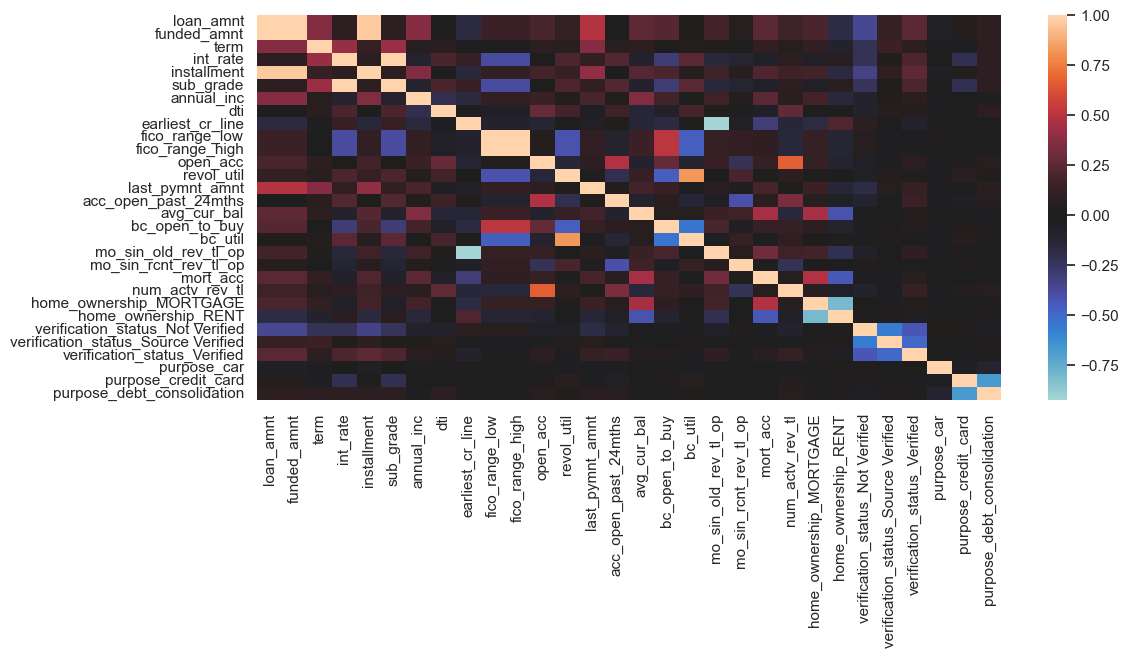

In [130]:
sns.heatmap(feature_correlation, 
        xticklabels=feature_correlation.columns,
        yticklabels=feature_correlation.columns, center=0)

In [131]:
# Solo usaremos la matriz triangular
# Recuerda que la matriz de correlacion es simetrica
upper = feature_correlation.where(np.triu(np.ones(
    feature_correlation.shape), k=1).astype(bool))

# Encuentra variables con correlacion mayor a threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

to_drop

['funded_amnt', 'installment', 'sub_grade', 'fico_range_high']

In [132]:
# Eliminar columnas 
data_train.drop(to_drop, axis=1, inplace=True)
data_test.drop(to_drop, axis=1, inplace=True)

<AxesSubplot: >

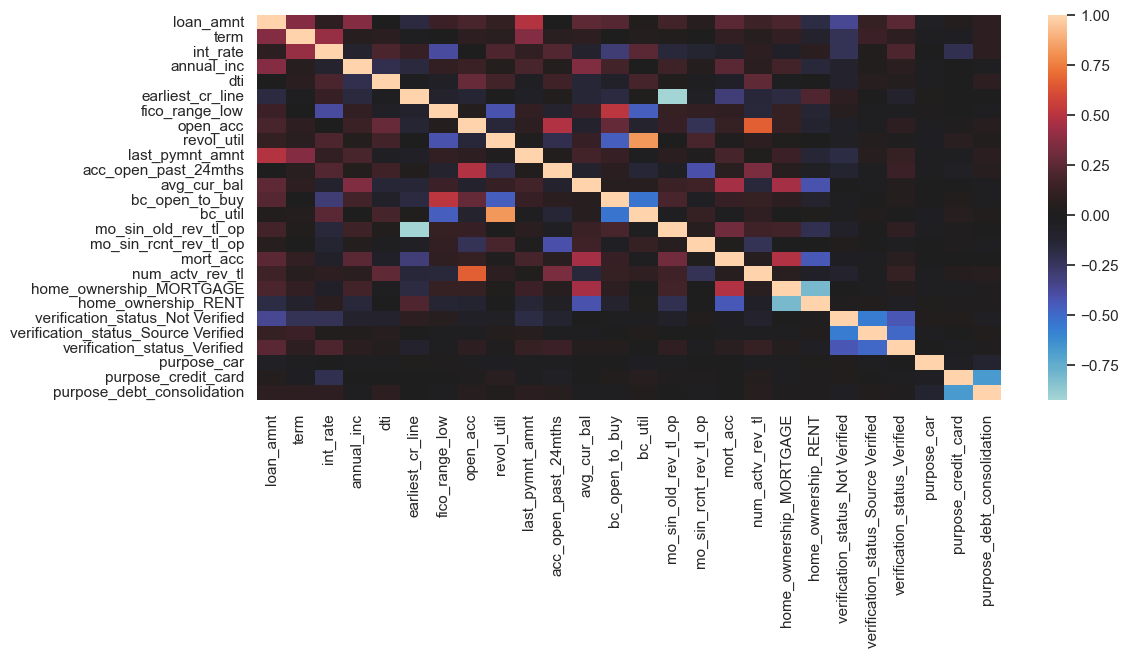

In [133]:
feature_correlation = data_train.loc[:, data_train.columns != 'charged_off'].corr()
sns.heatmap(feature_correlation, 
        xticklabels=feature_correlation.columns,
        yticklabels=feature_correlation.columns, center=0)

# Modelaje

**Nota**: Para conducir los procesos anteriores no dividimos train y test, por lo que existe **leakage** en nuestro modelo. Sin embargo, dado que este es un subsample (150K) de la base completa (887K) no hay tanto problema pues tenemos muchas observaciones para hacer validacion.  

Sin embargo, cualquier division que hagamos de los datos que ya analizamos tendra leakage. Por ejemplo, vamos a subestimar el error, pues usamos correlacion con la varaible objetivo para elegir variables.  

Normalemente se hacen analisis de esta manera si sabemos que tendremos mucho mas datos nuevos. Aunque, en estricto sentido esta mal, pero nos ayuda a ahorrarnos tiempo y hacer el codigo mas sencillo. Pues no tenemos que manejar diferentes bases.  

Lo correcto es al acabar este analisis, es optimizar/refactor el codigo que tenemos y entonces si hacer un analisis con lo aprendido y con los datos divididos desde el inicio.

Hay algoritmos que pueden manejar el imbalance de clases automaticamente sin necesidad de hacer sub/over-sampling.Es recomendable utilizarlos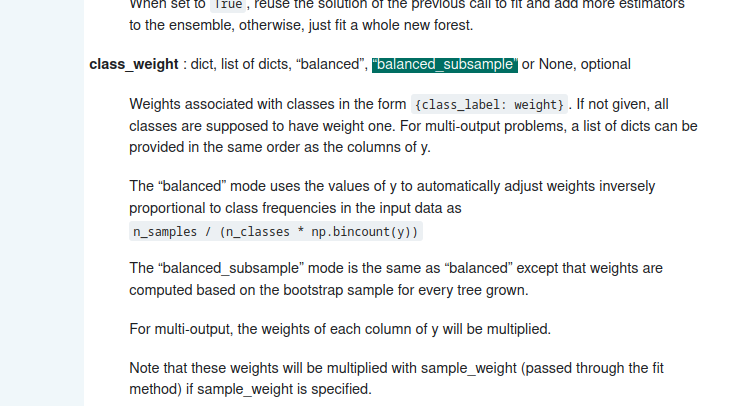

In [134]:
df_train = data_train.copy()
df_test = data_test.copy()
df_train.rename(columns={'charged_off':'y'}, inplace=True)
df_test.rename(columns={'charged_off':'y'}, inplace=True)

In [135]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_train = pd.DataFrame(imp_mean.fit_transform(df_train), columns=df_train.columns)

df_test = pd.DataFrame(imp_mean.fit_transform(df_test), columns=df_test.columns)


In [136]:
print(df_test.shape)
print(df_train.shape)

(17228, 27)
(68909, 27)


## (sub) Sampleo de Datos

Dado que tenemos clases desbalanceadas podemos realizar subsampling (reduccion) de la clase con mas etiquetas, o oversampling (aumento) de la clase con menos etiquetas.  Para la clase realizaremos, subsampling. De **tarea** realiza oversampling (seccion de abajo).

In [137]:
df_train_sub = df_train.copy()

In [138]:
df_train_sub['y'].value_counts()

0.0    55984
1.0    12925
Name: y, dtype: int64

In [139]:
default_0 = df_train_sub[df_train_sub['y']==0]
default_1 = df_train_sub[df_train_sub['y']==1]
# Subsample default_0
default_0 = default_0.sample(n=default_1.shape[0], random_state=152, 
                             replace=False)
# Merge datasets
df_train_sub = pd.concat([default_1, default_0],ignore_index=True)
df_train_sub = df_train_sub.sample(frac=1.0).reset_index(drop=True)
df_train_sub['y'].value_counts()

0.0    12925
1.0    12925
Name: y, dtype: int64

## (over) Sampleo de Datos

La siguiente celda contiene el codigo de oversampling.  
+ Piensa si el oversampling de datos deberia hacerse despues o antes de train/test, o de alguna otra forma?
**Haganlo en el CV no antes para no repetir observaciones**. Aqui esta mal hecho pues se hizo antes de separar por CV, lo cual causa que existan observaciones repetidas en el train y validacion/test de los sets del Cross Validation. Es un error!

In [140]:
df_train_over = df_train.copy()
df_train_over['y'].value_counts()

0.0    55984
1.0    12925
Name: y, dtype: int64

In [141]:
default_0 = df_train_over[df_train_over['y']==0]
default_1 = df_train_over[df_train_over['y']==1]
# Subsample default_1
default_1 = default_1.sample(frac=default_0.shape[0]/default_1.shape[0], random_state=152, 
                             replace=True)
default_1.shape

(55984, 27)

In [142]:
# Merge datasets
df_train_over = pd.concat([default_1, default_0],ignore_index=True)
df_train_over['y'].value_counts()

1.0    55984
0.0    55984
Name: y, dtype: int64

## Peso de observaciones (Tarea)

Usando ChatGPT busca como ponderar las observaciones en la funcion de perdida de manera que no se haga (sub) u (over) sample. Sino que se utilicen todas las observaciones, pero aun asi no nos afecte el problema de que hay muchas observaciones de un label y pocas de otra. La idea es utilizar todas las observaciones sin que se afecte.  

Hay muchas formas de hacerlo, tu tarea ses investigarla, crear el codigo y re-entrenar el modelo para poder comparar los resultados, recuerda que debes mantener el **train**, **validation**, y  **test** igual para poder comparar los resultados.

Modifica el notebook tratando de manetener la estructura, puedes agregar codigo en donde desees.

In [143]:
# Pesos Random Forests
df_train['y'].value_counts()

total_0 = (df_train['y'].value_counts())[0]
total_1 = (df_train['y'].value_counts())[1]
total = len(df_train)

print(total_0, total_1, total)

peso_0 = total/(1.2 * total_0)
peso_1 = total/(1.2 * total_1)

print(peso_0, peso_1)

# Defino el diccionario con las clases
dic_rf = {0: peso_0, 1: peso_1}

55984 12925 68909
1.0257246117938459 4.44287556415216


In [144]:
# Pesos para LDA
pesos = [peso_0, peso_1]

# Normalizo
suma = sum(pesos)
pesos = [p / suma for p in pesos]

print(pesos)

[0.18756621050951255, 0.8124337894904874]


In [145]:
# Para KNN
X_train = df_train.drop(columns=['y'])
Y_train = df_train['y']

matriz = {'V': np.cov(X_train[Y_train == 1], rowvar=False)}
matriz['V'].shape
print(matriz)

{'V': array([[ 7.02363888e+07,  4.38954530e+04,  6.58670477e+03,
         1.70183356e+08, -5.01127645e+01, -9.35048742e+03,
         3.08961940e+04,  8.74022749e+03,  1.97743389e+04,
         1.98737642e+06,  3.15140971e+02,  2.95406972e+07,
         1.83642405e+07,  5.08566486e+03,  1.19843605e+05,
         7.09579930e+03,  4.06955895e+03,  3.83250945e+03,
         8.89901009e+02, -7.92788266e+02, -1.06853798e+03,
         2.56422505e+02,  8.12115472e+02, -3.58033750e+01,
         8.94423342e+01,  2.82019062e+02],
       [ 4.38954530e+04,  1.39164978e+02,  2.07473904e+01,
         4.87774054e+04,  7.06610241e+00, -5.89935349e+00,
         2.26510699e+01,  6.62045420e+00,  1.42835533e+01,
         5.17141215e+02,  5.86510778e-01,  2.02866359e+04,
         8.32638345e+03,  7.39490799e+00,  7.17516006e+01,
         3.04973116e+00,  3.06058257e+00,  1.63994749e+00,
         8.38139757e-01, -7.33325934e-01, -1.18665438e+00,
         9.62638032e-01,  2.24016350e-01, -2.38546432e-02,
       

In [147]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

X_train = df_train.drop(columns=['y'])
Y_train = df_train['y']

mm_scaler = preprocessing.MinMaxScaler()   
X_train = mm_scaler.fit_transform(X_train)

# Calcular los pesos de muestra personalizados
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)

# Configurar GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=7364)

# Ajustar el modelo con los pesos de muestra personalizados
gmb_modelo = gb_model.fit(X_train, Y_train, sample_weight=sample_weights)


In [147]:
# Normalizacion
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def model_selection(df_train, num_folds=3, seed = 7364, scoring=["accuracy","balanced_accuracy","roc_auc", "f1"]):
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    mm_scaler = preprocessing.MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)

    # spot check the algorithms
    models = []
    models.append(('DC', DummyClassifier(strategy="stratified")))
    
    models.append(('LR', LogisticRegression(max_iter=500, class_weight = 'balanced')))

    models.append(('LDA', LinearDiscriminantAnalysis(priors = pesos)))

    # models.append(('KNN', KNeighborsClassifier(metric='mahalanobis', metric_params = matriz)))

    models.append(('KNN', KNeighborsClassifier(metric='manhattan')))

    models.append(('CART', DecisionTreeClassifier(class_weight = 'balanced', random_state = 453890)))

    #models.append(('NB', GaussianNB()))

    #Neural Network
    models.append(('NN', MLPClassifier(max_iter=500, solver='sgd', 
                                    early_stopping=True)))

    #Ensable Models 
    # Boosting methods
    #models.append(('AB', AdaBoostClassifier()))

    # Bagging methods
    models.append(('RF', RandomForestClassifier(class_weight = dic_rf)))

    #models.append(('ET', ExtraTreesClassifier()))

    results = [] 
    for name, model in models:
        print(f"Model: {name}")
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_validate(model, X_train, Y_train, cv=kfold,
                                    scoring=scoring, n_jobs=-1)
        cv_results = pd.DataFrame(cv_results)
        #print(cv_results.mean())
        # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        # print(msg)
        # cv_results = pd.DataFrame({
        #     'results':cv_results
        # })
        cv_results.loc[:,'model_name'] = name
        results.append(cv_results)

    # Convertir todos los resultados un solo DataFrame
    results = pd.concat(results, ignore_index=True)
    print(results.groupby(['model_name'], as_index=False).describe())
    results_plot =  [c for c in results.columns if 'time' not in c]
    results_plot = results.loc[:,results_plot]
    results_plot = pd.melt(
        results_plot, id_vars='model_name', var_name="metric")
    #results_plot = results_plot[results_plot['metric']]
    g = sns.FacetGrid(results_plot, row="metric",
                      height=3, aspect=1, sharex=False)
    g.map(sns.boxplot, 'model_name','value')
    g.fig.set_size_inches(13, 20)
    
    return results

Model: DC


Model: LR
Model: LDA
Model: KNN
Model: CART
Model: NN
Model: RF
  fit_time                                                                   \
     count       mean       std        min        25%        50%        75%   
0      5.0   1.712623  0.078110   1.595696   1.697679   1.728555   1.728555   
1      5.0   0.020257  0.006573   0.015627   0.015627   0.015639   0.024716   
2      5.0   0.027922  0.007220   0.015017   0.030661   0.031311   0.031311   
3      5.0   0.321996  0.052350   0.276542   0.276542   0.300174   0.378360   
4      5.0   1.038584  0.138608   0.858252   1.009655   1.035876   1.042054   
5      5.0  13.690913  2.360256  10.463508  11.942274  14.742449  15.616140   
6      5.0  20.268388  0.190771  20.033587  20.227265  20.249362  20.266046   

             score_time             ... test_roc_auc           test_f1  \
         max      count       mean  ...          75%       max   count   
0   1.812630        5.0   0.034479  ...     0.757688  0.763398     5.0   
1 

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


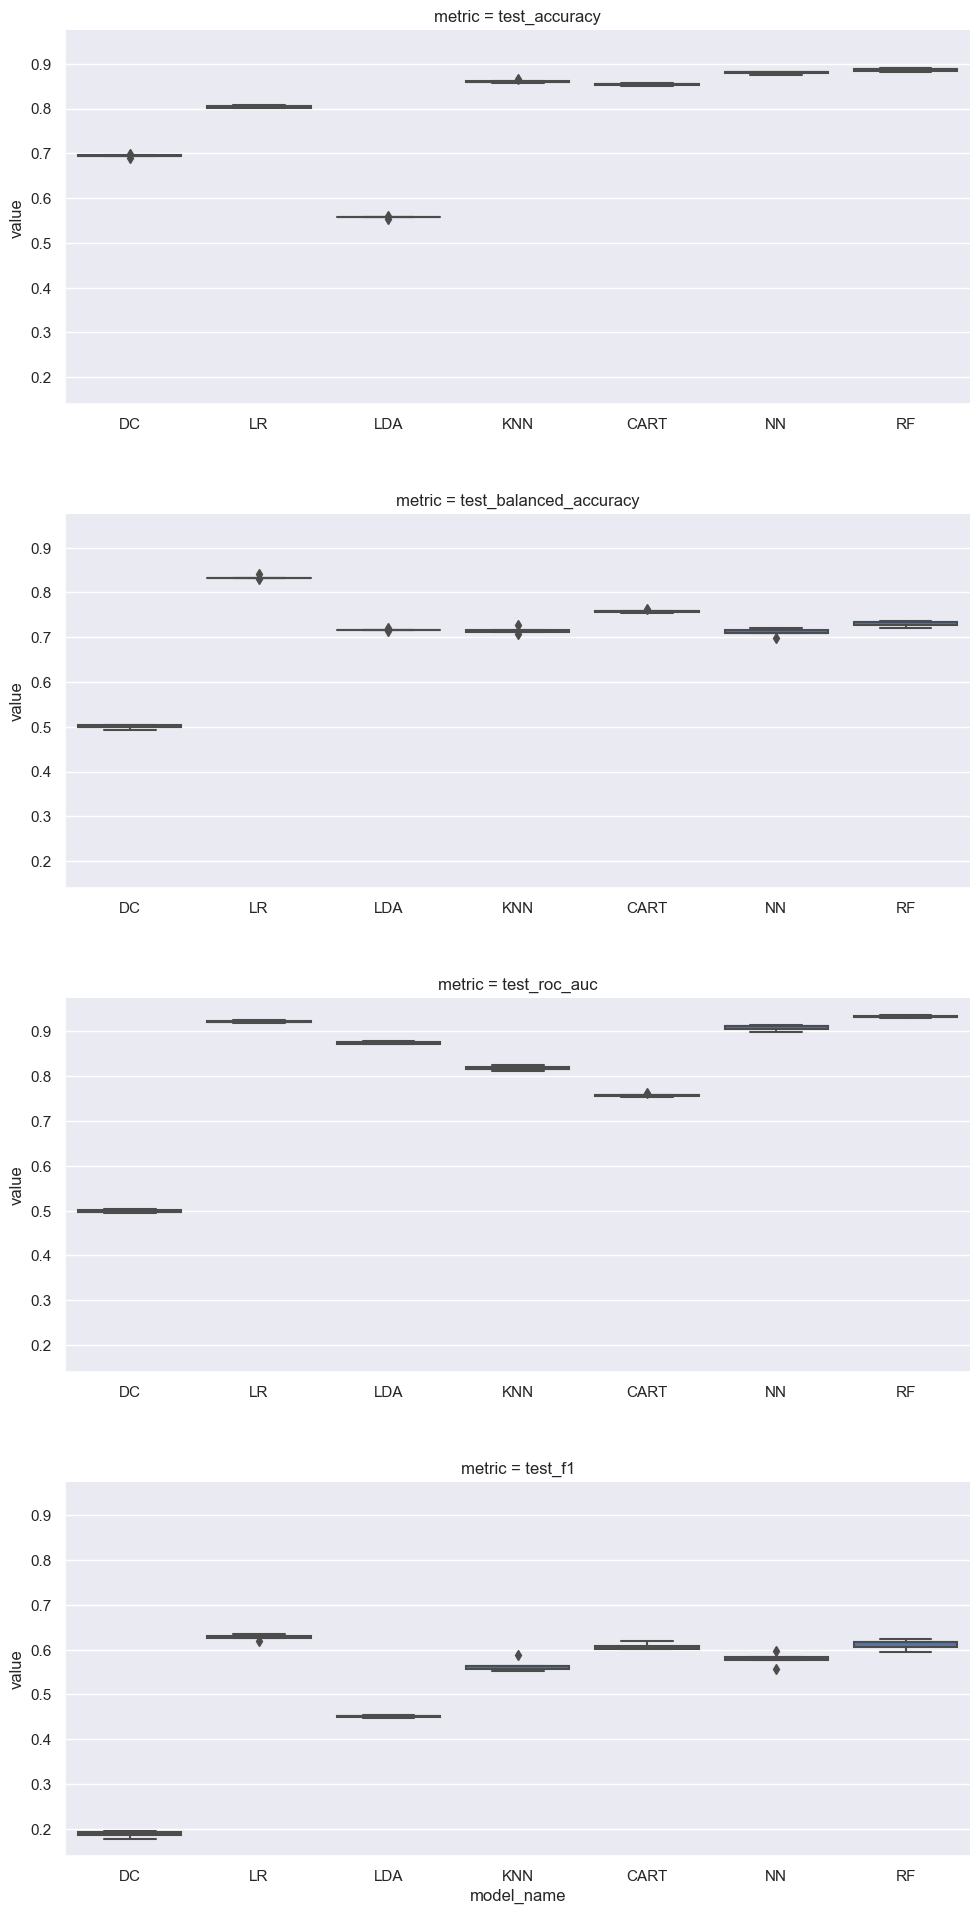

In [148]:
df_result_all = model_selection(df_train, num_folds=5)

Model: DC
Model: LR
Model: LDA
Model: KNN
Model: CART
Model: NN
Model: RF
  fit_time                                                                  \
     count      mean           std       min       25%       50%       75%   
0      5.0  0.610410  1.785469e-02  0.588512  0.604138  0.604138  0.619763   
1      5.0  0.008001  1.305872e-07  0.008001  0.008001  0.008001  0.008001   
2      5.0  0.015555  3.060110e-05  0.015542  0.015542  0.015542  0.015542   
3      5.0  0.130887  1.716019e-02  0.118330  0.118330  0.118404  0.149685   
4      5.0  0.351129  1.904848e-02  0.327566  0.343215  0.347324  0.358854   
5      5.0  8.549744  6.340133e-01  7.498011  8.572954  8.662398  8.821789   
6      5.0  8.865307  7.271949e-02  8.786945  8.819323  8.853278  8.891942   

            score_time            ... test_roc_auc           test_f1  \
        max      count      mean  ...          75%       max   count   
0  0.635499        5.0  0.015649  ...     0.807454  0.819561     5.0   
1  0.00

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


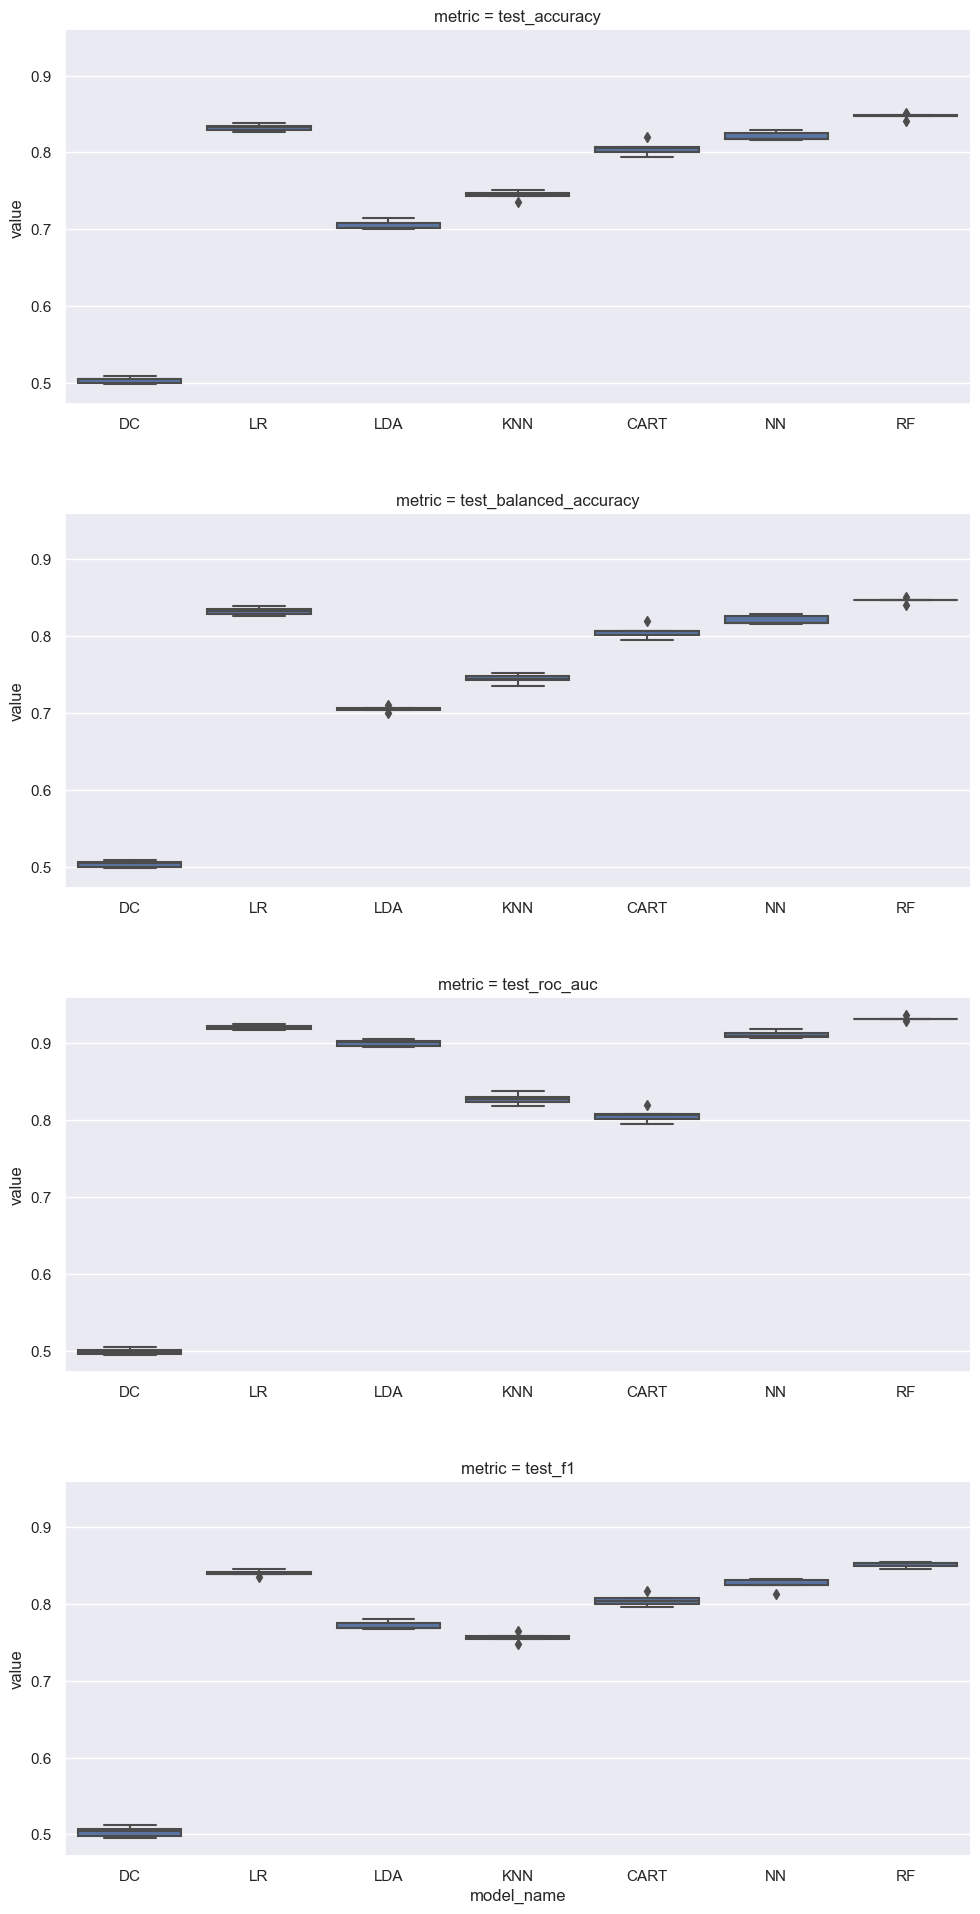

In [149]:
# Subsampleo
df_result_sub = model_selection(df_train_sub, num_folds=5)

Model: DC
Model: LR
Model: LDA
Model: KNN
Model: CART
Model: NN
Model: RF
  fit_time                                                                   \
     count       mean       std        min        25%        50%        75%   
0      5.0   2.651542  0.092313   2.509859   2.642720   2.662566   2.676084   
1      5.0   0.038403  0.003578   0.032002   0.040002   0.040002   0.040003   
2      5.0   0.033167  0.007360   0.029166   0.029166   0.030616   0.030616   
3      5.0   0.617644  0.023410   0.589963   0.600979   0.616520   0.632858   
4      5.0   2.190485  0.221887   1.798922   2.255970   2.256181   2.297108   
5      5.0  29.684673  6.009630  22.527817  25.152530  29.636145  34.172390   
6      5.0  38.314526  0.380731  37.795878  38.175057  38.227839  38.629928   

             score_time              ... test_roc_auc           test_f1  \
         max      count        mean  ...          75%       max   count   
0   2.766482        5.0    0.042228  ...     0.945339  0.946390 

C:\Users\maria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


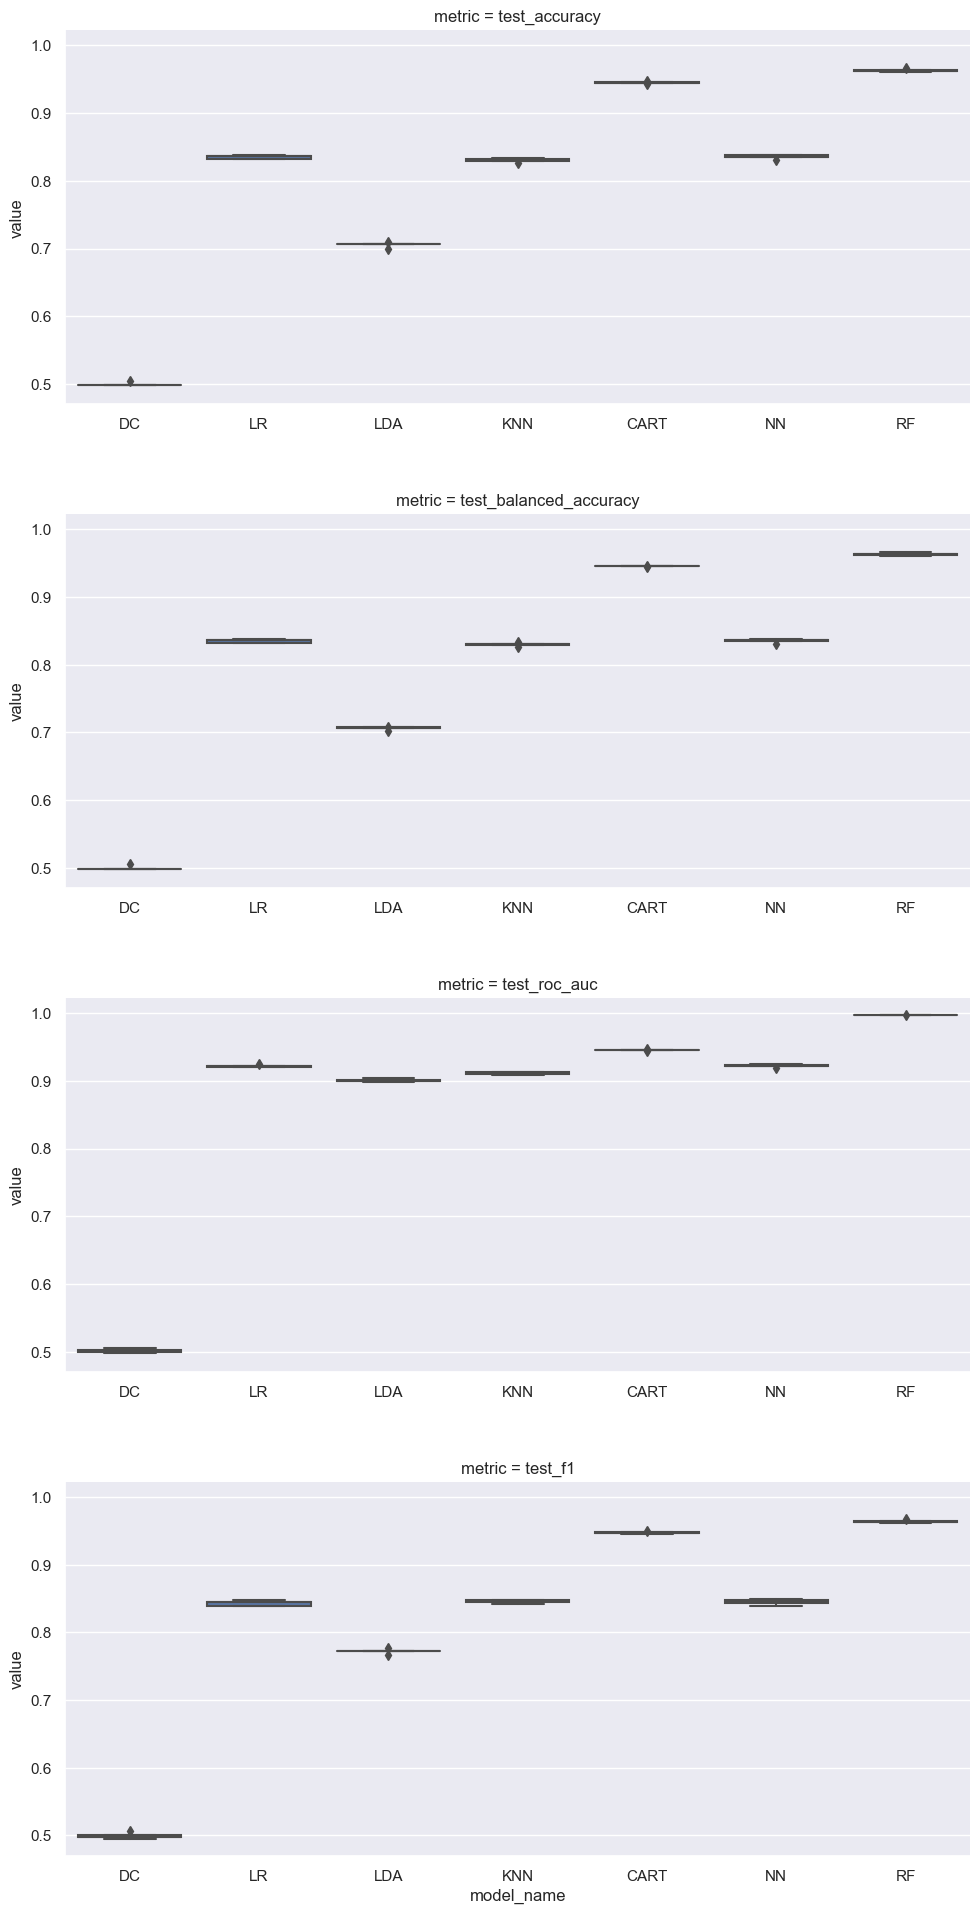

In [150]:
# Oversampling
df_result_over = model_selection(df_train_over, num_folds=5)

In [151]:
def fine_tuning(df_train, model, param_grid, scoring="balanced_accuracy", k_fold=5, seed=345):
    
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    mm_scaler = preprocessing.MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)

    kfold = KFold(n_splits=k_fold, random_state=seed, shuffle=True)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring,
                        cv=kfold, n_jobs=-1)
    grid_result = grid.fit(X_train, Y_train)

    #Print Results
    print("Mejor: %f using %s" %
        (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    ranks = grid_result.cv_results_['rank_test_score']
    for mean, stdev, param, rank in zip(means, stds, params, ranks):
        print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))
        
    return grid_result


In [152]:
# all_model = fine_tuning(df_train, model=model, param_grid=param_grid,
#                         scoring="balanced_accuracy", k_fold=5, seed=345)
# pd.DataFrame(all_model.cv_results_)

In [153]:
from sklearn.metrics import roc_curve
from sklearn import metrics

def evaluate_test(df_train, df_test, model):
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    X_test = df_test.drop(columns=['y'])
    Y_test = df_test['y']

    mm_scaler = preprocessing.MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)
    X_test = mm_scaler.transform(X_test)

    predictions = model.predict(X_test)
    print(accuracy_score(Y_test, predictions))
    print(confusion_matrix(Y_test, predictions))
    print(classification_report(Y_test, predictions))


    predictions_p = model.predict_proba(X_test)
    f, axes = plt.subplots(2, 1)
    metrics.roc_curve(Y_test, predictions_p[:, 1])
    metrics.roc_auc_score(Y_test, predictions_p[:, 1])
    
    df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions),
                         columns=np.unique(Y_test), index=np.unique(Y_test))
    df_cm.index.name = 'Verdadero'
    df_cm.columns.name = 'Predecido'

    names = ['b', 'c']
    sns.heatmap(df_cm, cmap="Blues", annot=True,
                annot_kws={"size": 16})  # font sizes
    return model


In [154]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

def evaluate_test(df_train, df_test, model_name):
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    X_test = df_test.drop(columns=['y'])
    Y_test = df_test['y']

    mm_scaler = MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)
    X_test = mm_scaler.transform(X_test)

    if model_name == "DC":
        model = DummyClassifier(strategy="most_frequent")
    elif model_name == "LR":
        model = LogisticRegression(max_iter=500)
    elif model_name == "LDA":
        model = LinearDiscriminantAnalysis()
    elif model_name == "KNN":
        model = KNeighborsClassifier()
    elif model_name == "CART":
        model = DecisionTreeClassifier()
    elif model_name == "NN":
        model = MLPClassifier(max_iter=500, solver='sgd', early_stopping=True)
    elif model_name == "RF":
        model = RandomForestClassifier()

    model.fit(X_train, Y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(Y_test, predictions)
    confusion = confusion_matrix(Y_test, predictions)
    classification_rep = classification_report(Y_test, predictions)

    predictions_p = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, predictions_p[:, 1])
    roc_auc = roc_auc_score(Y_test, predictions_p[:, 1])

    df_cm = pd.DataFrame(confusion, columns=np.unique(Y_test), index=np.unique(Y_test))
    df_cm.index.name = 'Verdadero'
    df_cm.columns.name = 'Predecido'

    names = ['b', 'c']
    sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})  # font sizes
    plt.show()

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion)
    print("Classification Report:")
    print(classification_rep)
    print(f"ROC AUC: {roc_auc:.4f}")


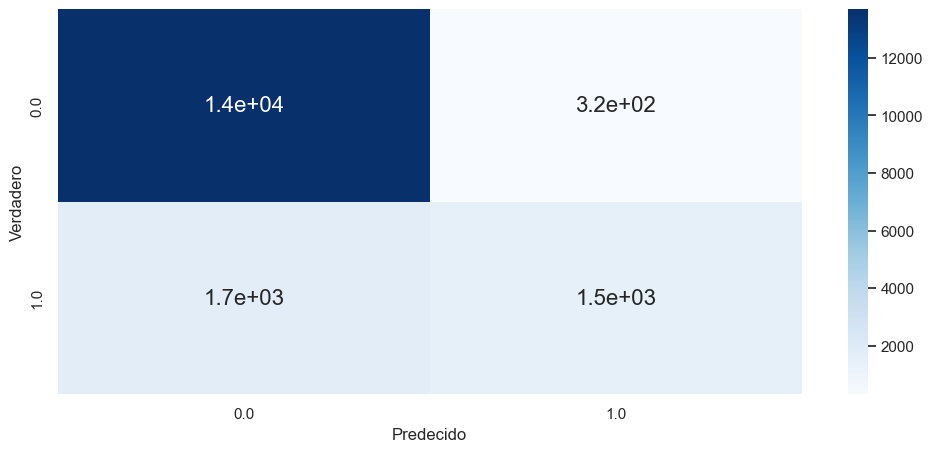

Model: LR
Accuracy: 0.8811
Confusion Matrix:
[[13679   318]
 [ 1731  1500]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     13997
         1.0       0.83      0.46      0.59      3231

    accuracy                           0.88     17228
   macro avg       0.86      0.72      0.76     17228
weighted avg       0.88      0.88      0.87     17228

ROC AUC: 0.9234


In [155]:
evaluate_test(df_train, df_test, "LR")

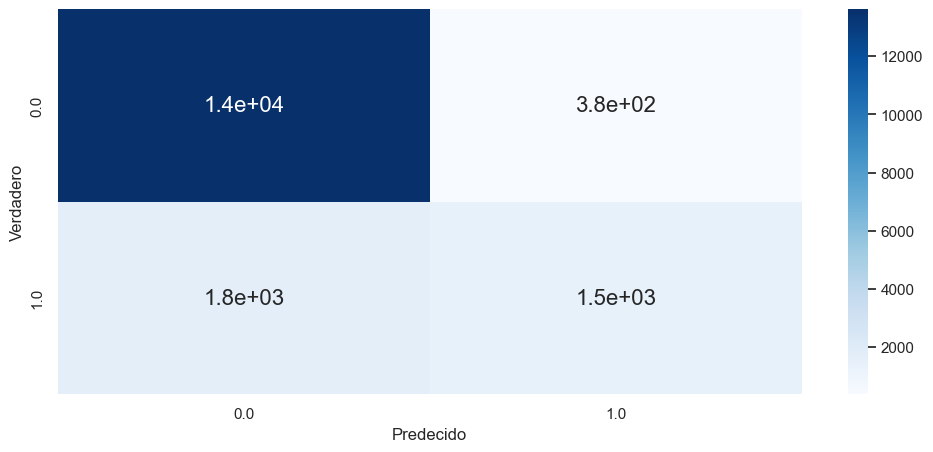

Model: LDA
Accuracy: 0.8754
Confusion Matrix:
[[13612   385]
 [ 1761  1470]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93     13997
         1.0       0.79      0.45      0.58      3231

    accuracy                           0.88     17228
   macro avg       0.84      0.71      0.75     17228
weighted avg       0.87      0.88      0.86     17228

ROC AUC: 0.8796


In [156]:
evaluate_test(df_train, df_test, "LDA")

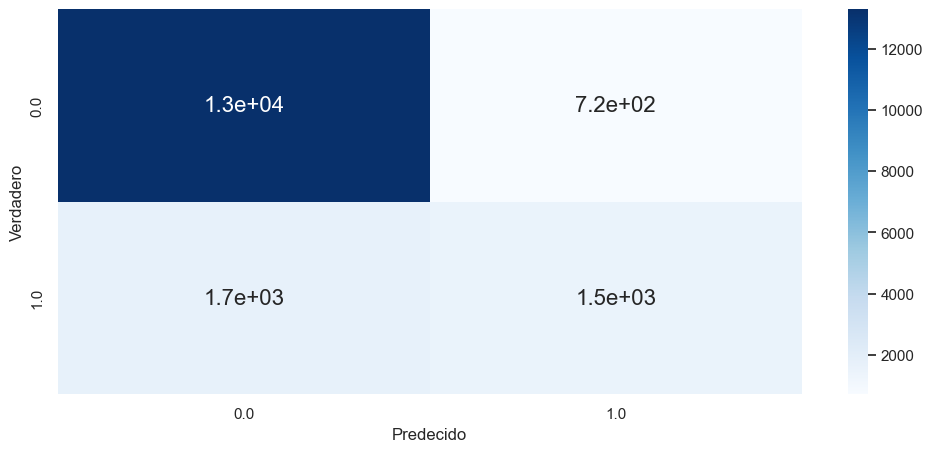

Model: KNN
Accuracy: 0.8596
Confusion Matrix:
[[13281   716]
 [ 1703  1528]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     13997
         1.0       0.68      0.47      0.56      3231

    accuracy                           0.86     17228
   macro avg       0.78      0.71      0.74     17228
weighted avg       0.85      0.86      0.85     17228

ROC AUC: 0.8173


In [157]:
evaluate_test(df_train, df_test, "KNN")

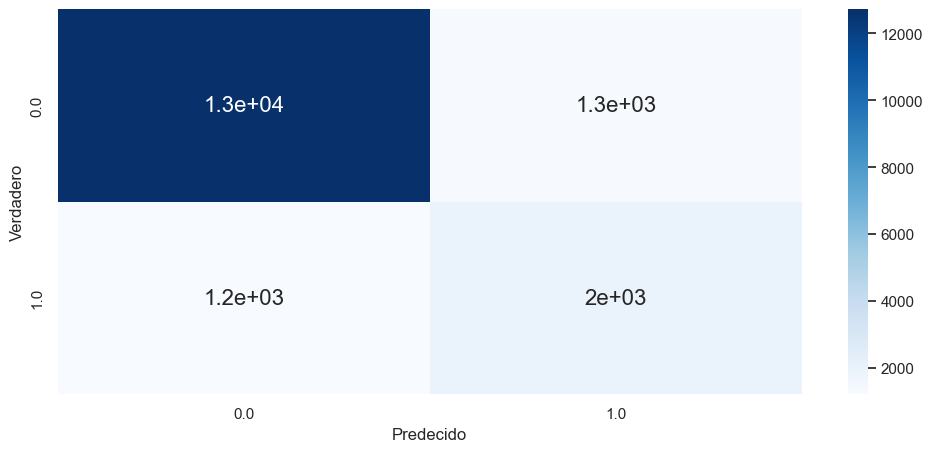

Model: CART
Accuracy: 0.8555
Confusion Matrix:
[[12723  1274]
 [ 1215  2016]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     13997
         1.0       0.61      0.62      0.62      3231

    accuracy                           0.86     17228
   macro avg       0.76      0.77      0.76     17228
weighted avg       0.86      0.86      0.86     17228

ROC AUC: 0.7665


In [158]:
evaluate_test(df_train, df_test, "CART")

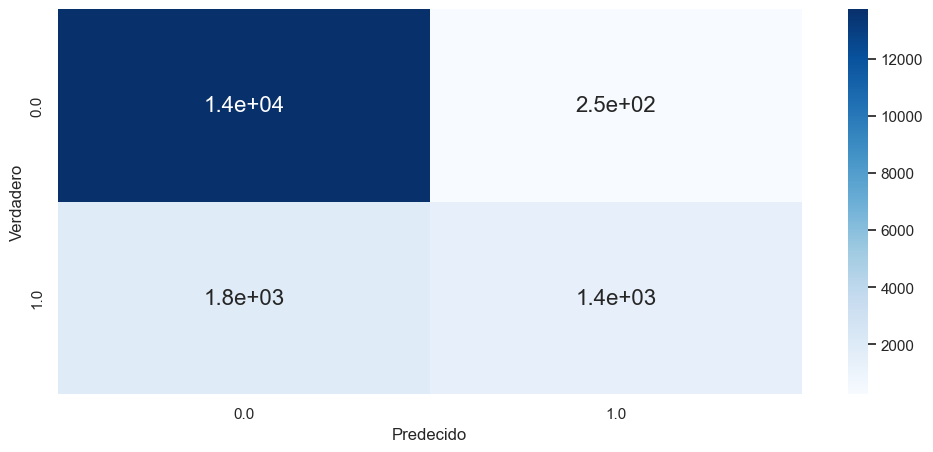

Model: NN
Accuracy: 0.8790
Confusion Matrix:
[[13746   251]
 [ 1834  1397]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     13997
         1.0       0.85      0.43      0.57      3231

    accuracy                           0.88     17228
   macro avg       0.86      0.71      0.75     17228
weighted avg       0.88      0.88      0.86     17228

ROC AUC: 0.9100


In [159]:
evaluate_test(df_train, df_test, "NN")

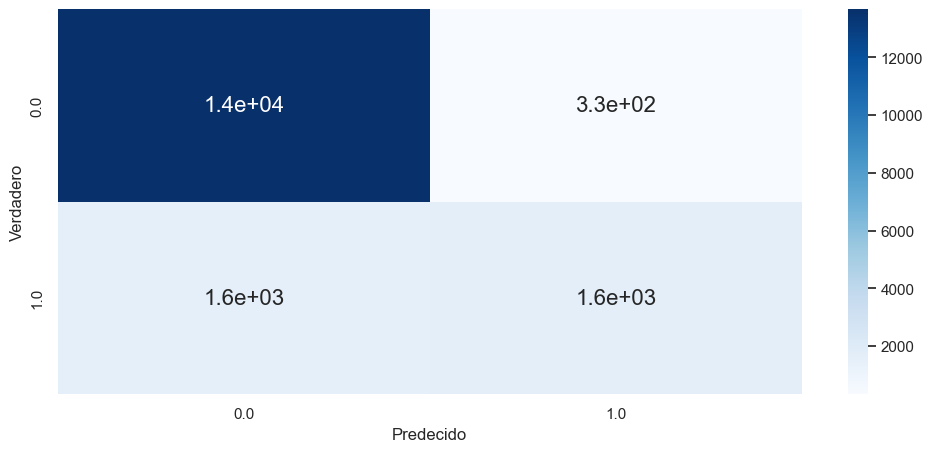

Model: RF
Accuracy: 0.8883
Confusion Matrix:
[[13668   329]
 [ 1596  1635]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.93     13997
         1.0       0.83      0.51      0.63      3231

    accuracy                           0.89     17228
   macro avg       0.86      0.74      0.78     17228
weighted avg       0.88      0.89      0.88     17228

ROC AUC: 0.9357


In [176]:
evaluate_test(df_train, df_test, "RF")

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94     13997
         1.0       0.82      0.55      0.66      3231

    accuracy                           0.89     17228
   macro avg       0.86      0.76      0.80     17228
weighted avg       0.89      0.89      0.88     17228



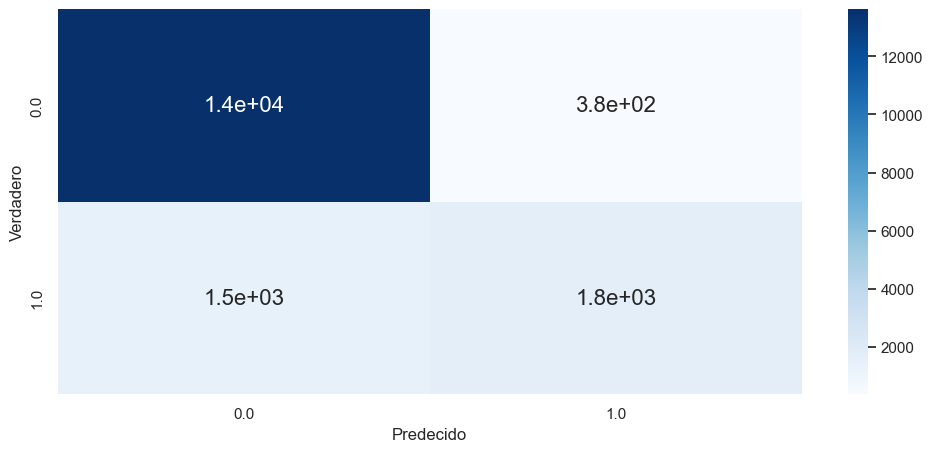

In [ ]:
final_trained_model = evaluate_test(df_train, df_test, gmb_modelo)

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

X_test = df_test.drop(columns=['y'])
Y_test = df_test['y']

# Define los modelos y los rangos de hiperparámetros que deseas buscar
models = {
#     'LR': (LogisticRegression(max_iter = 500, class_weight = 'balanced'),
#            {'C': [0.001, 0.01, 0.1, 1,10,100, 1000]}),
    # 'RF': (RandomForestClassifier(class_weight = dic_rf),
    #        {'n_estimators': [50, 100, 150, 200],
    #         'max_depth': [3, 5, 7, 9]}),
    'GBM': (GradientBoostingClassifier(),
            {'n_estimators': [50, 100, 150, 200],
             'max_depth': [3, 4, 5, 6]})
}

# Realiza la búsqueda de hiperparámetros y la evaluación para cada modelo
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, Y_train)  # Ajusta el modelo a los datos de entrenamiento
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Imprime los resultados
    print(f"Mejor {model_name}: {best_score} using {best_params}")
    
    # Evalúa el modelo en el conjunto de prueba
    y_pred = grid_search.predict(X_test)
    report = classification_report(Y_test, y_pred)
    print(report)


KeyboardInterrupt: 

## Modelos

Scoring Metrics [source](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [ ]:
# Normalizacion
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

def model_selection(df_train, num_folds=3, seed = 7364, scoring=["accuracy","balanced_accuracy","roc_auc", "f1"]):
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    mm_scaler = preprocessing.MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)

    # spot check the algorithms
    models = []
    #models.append(('DC', DummyClassifier(strategy="most_frequent")))
    models.append(('LR', LogisticRegression(max_iter=500)))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    #models.append(('CART', DecisionTreeClassifier()))
    #models.append(('NB', GaussianNB()))
    #Neural Network
    models.append(('NN', MLPClassifier(max_iter=500, solver='sgd', 
                                    early_stopping=True)))
    #Ensable Models 
    # Boosting methods
    #models.append(('AB', AdaBoostClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    # Bagging methods
    models.append(('RF', RandomForestClassifier()))
    #models.append(('ET', ExtraTreesClassifier()))

    # ##Opciones

    results = [] 

    for name, model in models:
        print(f"Model: {name}")
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_validate(model, X_train, Y_train, cv=kfold,
                                    scoring=scoring, n_jobs=-1)
        cv_results = pd.DataFrame(cv_results)
        #print(cv_results.mean())
        # msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        # print(msg)
        # cv_results = pd.DataFrame({
        #     'results':cv_results
        # })
        cv_results.loc[:,'model_name'] = name
        results.append(cv_results)

    # Convertir todos los resultados un solo DataFrame
    results = pd.concat(results, ignore_index=True)
    print(results.groupby(['model_name'], as_index=False).describe())
    results_plot =  [c for c in results.columns if 'time' not in c]
    results_plot = results.loc[:,results_plot]
    results_plot = pd.melt(
        results_plot, id_vars='model_name', var_name="metric")
    #results_plot = results_plot[results_plot['metric']]
    g = sns.FacetGrid(results_plot, row="metric",
                      height=3, aspect=1, sharex=False)
    g.map(sns.boxplot, 'model_name','value')
    g.fig.set_size_inches(13, 20)
    
    return results

Model: LR
Model: LDA


Model: KNN
Model: NN
Model: GBM
Model: RF
  fit_time                                                                   \
     count       mean       std        min        25%        50%        75%   
0      5.0  30.025662  1.159775  28.745520  28.953962  30.170891  30.866918   
1      5.0   0.022066  0.002814   0.017927   0.020483   0.023160   0.024109   
2      5.0   0.353038  0.031745   0.322917   0.327237   0.341075   0.384676   
3      5.0   1.224909  0.065685   1.156588   1.161461   1.235492   1.261946   
4      5.0  15.840122  1.208887  13.987549  15.607181  15.811227  16.649183   
5      5.0  20.109234  0.493495  19.437809  19.806860  20.280951  20.309339   

             score_time            ... test_roc_auc           test_f1  \
         max      count      mean  ...          75%       max   count   
0  31.391020        5.0  0.076632  ...     0.942833  0.944150     5.0   
1   0.024651        5.0  9.186287  ...     0.820841  0.823203     5.0   
2   0.389285        5.0  0.035957

/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


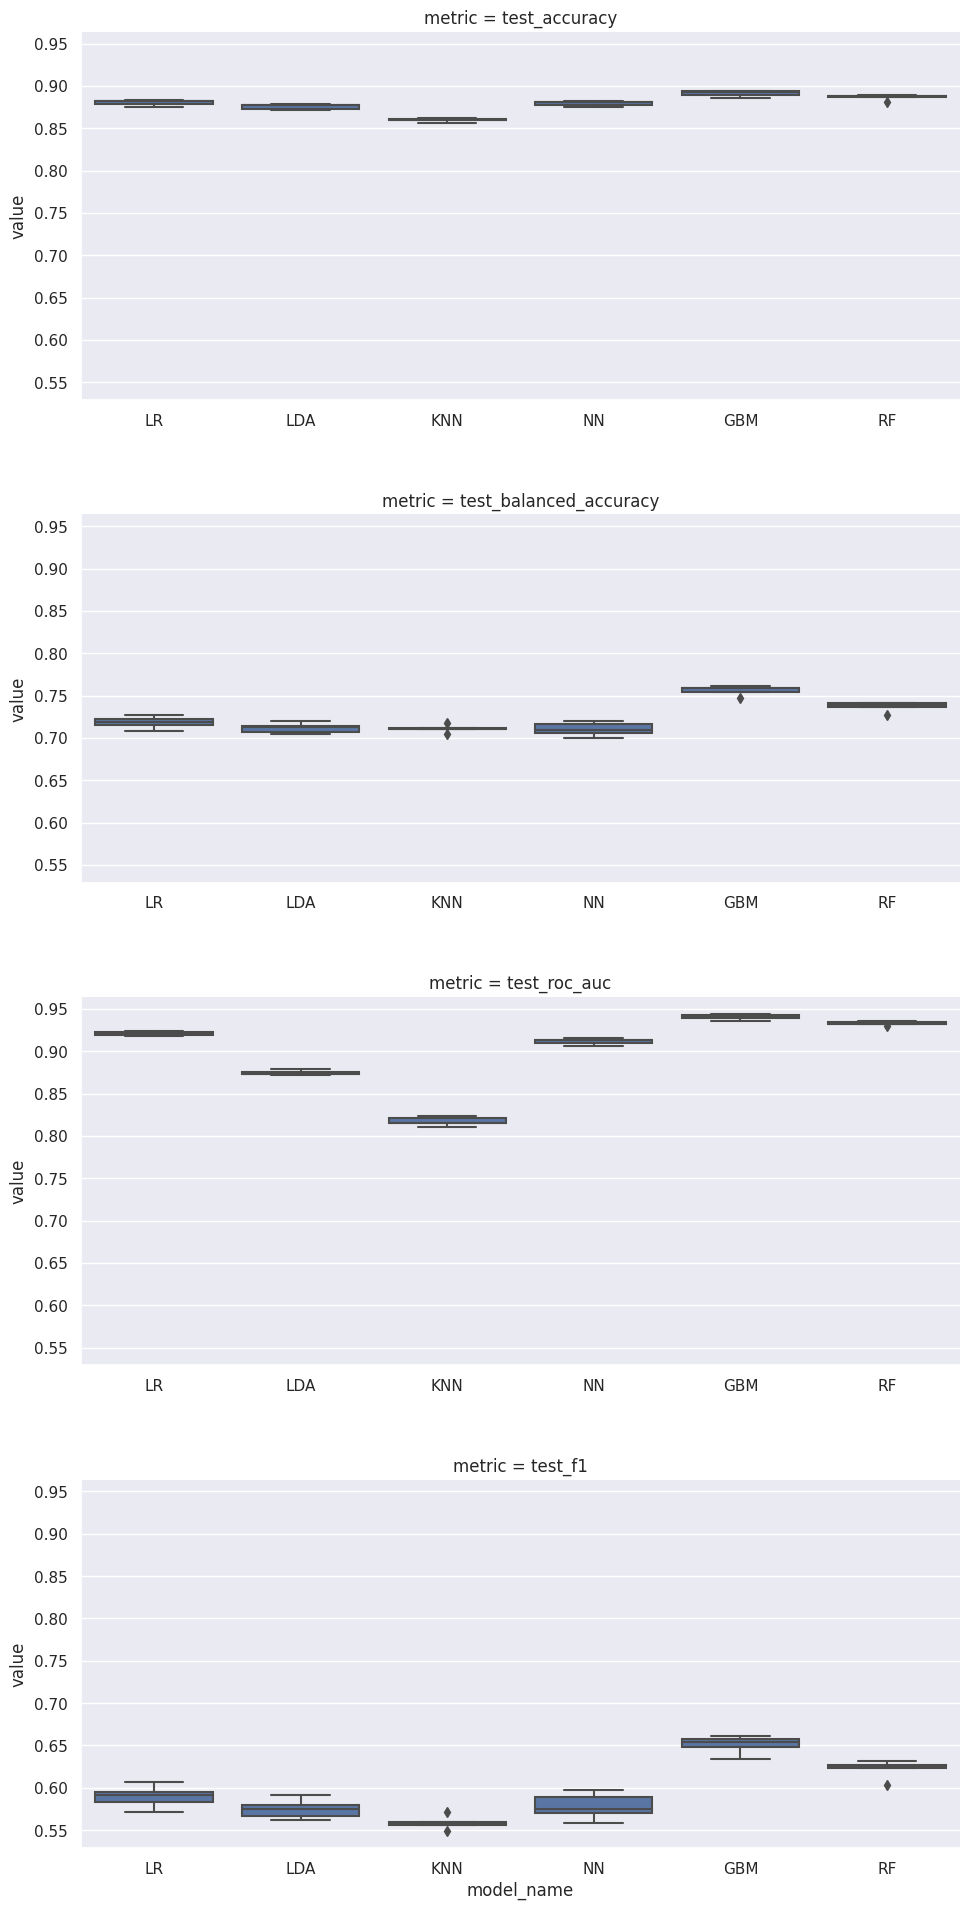

In [ ]:
df_result_all = model_selection(df_train, num_folds=5)

Model: LR


Model: LDA
Model: KNN
Model: NN
Model: GBM
Model: RF
  fit_time                                                                \
     count       mean       std       min       25%       50%        75%   
0      5.0  10.382057  0.976331  9.490072  9.567097  9.991223  11.429391   
1      5.0   0.011264  0.000450  0.010969  0.010987  0.011065   0.011256   
2      5.0   0.198711  0.019402  0.172631  0.187681  0.199620   0.211919   
3      5.0   0.354845  0.032821  0.325661  0.326939  0.343185   0.379754   
4      5.0   9.203722  1.326453  7.401325  8.226347  9.757863  10.158073   
5      5.0   7.709622  0.541814  6.755601  7.834643  7.874936   8.020315   

             score_time            ... test_roc_auc           test_f1  \
         max      count      mean  ...          75%       max   count   
0  11.432502        5.0  0.037097  ...     0.941504  0.942082     5.0   
1   0.012044        5.0  1.611556  ...     0.830427  0.831422     5.0   
2   0.221703        5.0  0.019746  ...     0.8

/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


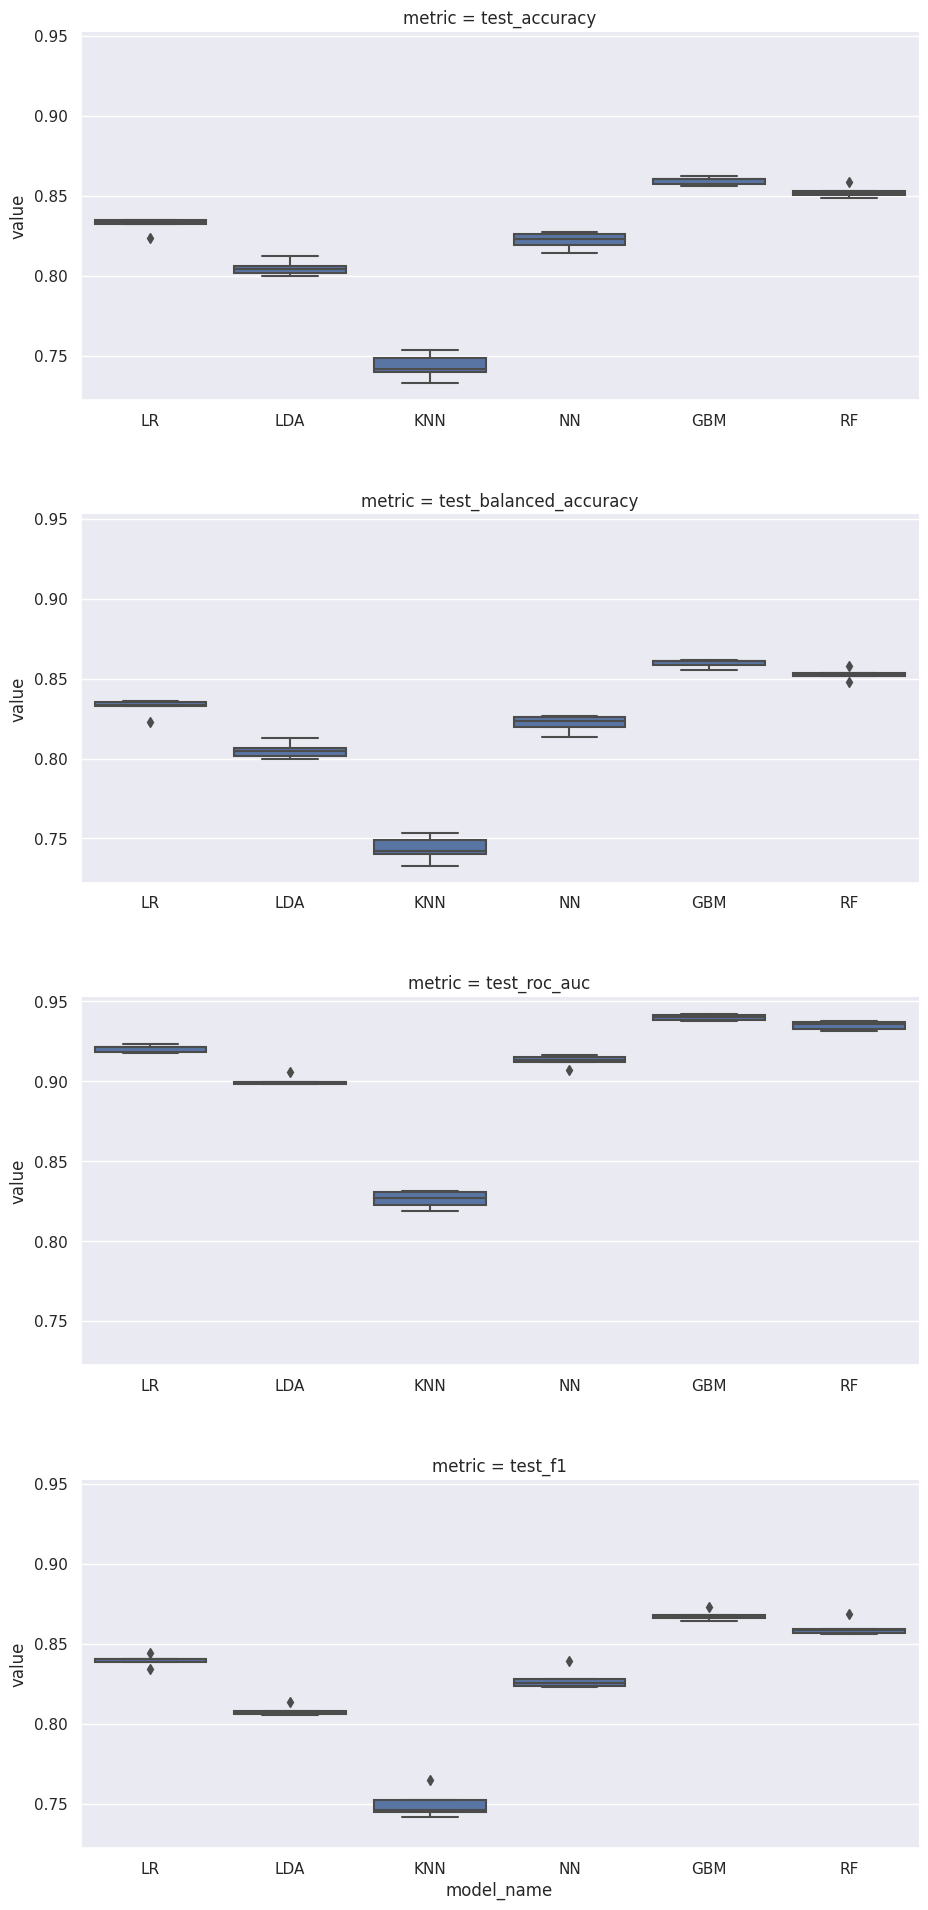

In [ ]:
df_result_sub = model_selection(df_train_sub, num_folds=5)

Model: LR


Model: LDA
Model: KNN
Model: NN
Model: GBM
Model: RF
  fit_time                                                                   \
     count       mean       std        min        25%        50%        75%   
0      5.0  49.645550  1.506242  47.961072  48.281540  49.762226  50.930206   
1      5.0   0.071410  0.005409   0.064647   0.068764   0.071627   0.072686   
2      5.0   0.787309  0.052207   0.741167   0.746986   0.760425   0.843392   
3      5.0   1.896521  0.112918   1.779826   1.830849   1.847132   1.968942   
4      5.0  28.640460  5.171545  26.026322  26.050389  26.122679  27.149654   
5      5.0  32.896808  1.770229  31.389421  31.774102  31.781416  34.159747   

             score_time             ... test_roc_auc           test_f1  \
         max      count       mean  ...          75%       max   count   
0  51.292703        5.0   0.114761  ...     0.943265  0.945338     5.0   
1   0.079324        5.0  25.964375  ...     0.914974  0.917746     5.0   
2   0.844574      

/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


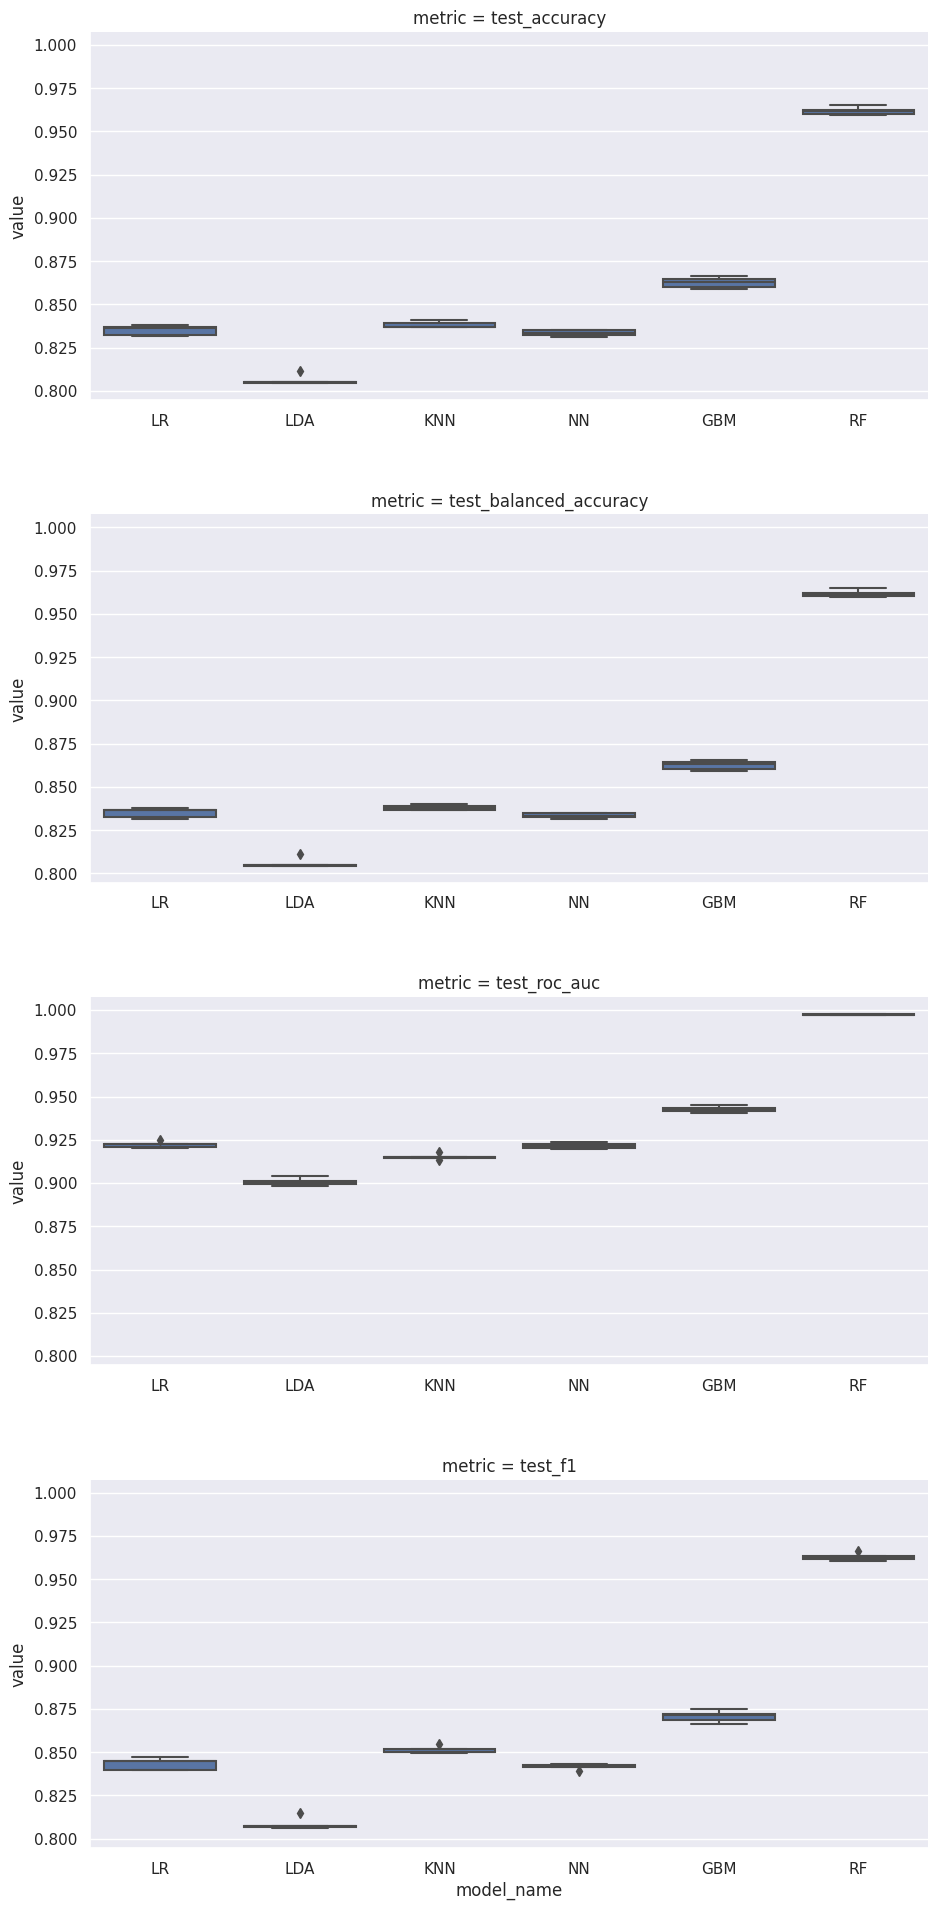

In [ ]:
df_result_over = model_selection(df_train_over, num_folds=5)


## Fine tuning

In [ ]:
# Grid Search: GradientBoosting
'''
n_estimators : int (default=100)
    Numero de boostings que realiza. Es bastante robusto a overfitting,
    en comparacion con otros algoritmos de boosting. Por lo que, podemos usar
    un numero grande.
max_depth : integer, optional (default=3)
    El depth o profundida de los estimadores individuales. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; 
    the best value depends on the interaction of the input variables.

'''
n_estimators = [50, 100, 150, 180]
max_depth = [5, 7]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()


In [ ]:
all_model = fine_tuning(df_train, model=model, param_grid=param_grid,
                        scoring="balanced_accuracy", k_fold=5, seed=345)
pd.DataFrame(all_model.cv_results_)


Mejor: 0.781346 using {'max_depth': 7, 'n_estimators': 150}
#8 0.759158 (0.004543) with: {'max_depth': 5, 'n_estimators': 50}
#6 0.771313 (0.005677) with: {'max_depth': 5, 'n_estimators': 100}
#5 0.773890 (0.005764) with: {'max_depth': 5, 'n_estimators': 150}
#3 0.776636 (0.004630) with: {'max_depth': 5, 'n_estimators': 180}
#7 0.766908 (0.005788) with: {'max_depth': 7, 'n_estimators': 50}
#4 0.775674 (0.005263) with: {'max_depth': 7, 'n_estimators': 100}
#1 0.781346 (0.004852) with: {'max_depth': 7, 'n_estimators': 150}
#2 0.781341 (0.005413) with: {'max_depth': 7, 'n_estimators': 180}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,37.578530,1.944942,0.062967,0.007983,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.762323,0.757991,0.751478,0.764888,0.759107,0.759158,0.004543,8
1,78.978937,1.907447,0.080213,0.013865,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.769637,0.768265,0.765070,0.781794,0.771801,0.771313,0.005677,6
2,115.657168,2.894767,0.116613,0.020236,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.772322,0.771033,0.767678,0.784700,0.773717,0.773890,0.005764,5
3,127.885669,7.896184,0.111791,0.010648,5,180,"{'max_depth': 5, 'n_estimators': 180}",0.776236,0.774623,0.772185,0.785527,0.774611,0.776636,0.004630,3
4,52.761378,0.855330,0.084597,0.028872,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.768154,0.762571,0.759291,0.776249,0.768277,0.766908,0.005788,7
5,103.381836,1.149170,0.095576,0.008112,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.776107,0.772955,0.769063,0.785004,0.775241,0.775674,0.005263,4
6,149.588892,3.444415,0.118866,0.012984,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.779853,0.778730,0.777018,0.790776,0.780353,0.781346,0.004852,1
7,150.771174,14.701197,0.089684,0.021339,7,180,"{'max_depth': 7, 'n_estimators': 180}",0.777018,0.780290,0.776566,0.791533,0.781299,0.781341,0.005413,2


In [ ]:
sub_model = fine_tuning(df_train_sub, model=model, param_grid=param_grid,
                        scoring="balanced_accuracy", k_fold=5, seed=345)
pd.DataFrame(sub_model.cv_results_)



Mejor: 0.862533 using {'max_depth': 7, 'n_estimators': 100}
#6 0.860534 (0.005162) with: {'max_depth': 5, 'n_estimators': 50}
#2 0.862282 (0.005868) with: {'max_depth': 5, 'n_estimators': 100}
#3 0.861739 (0.004962) with: {'max_depth': 5, 'n_estimators': 150}
#5 0.860578 (0.003874) with: {'max_depth': 5, 'n_estimators': 180}
#7 0.860529 (0.004340) with: {'max_depth': 7, 'n_estimators': 50}
#1 0.862533 (0.005327) with: {'max_depth': 7, 'n_estimators': 100}
#4 0.861403 (0.003455) with: {'max_depth': 7, 'n_estimators': 150}
#8 0.859974 (0.003509) with: {'max_depth': 7, 'n_estimators': 180}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.751431,0.837740,0.020627,0.001882,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.864742,0.860505,0.866128,0.851376,0.859918,0.860534,0.005162,6
1,24.593736,0.739241,0.029400,0.001891,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.869432,0.860016,0.865744,0.852231,0.863986,0.862282,0.005868,2
2,35.476699,1.720634,0.038405,0.010304,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.868682,0.858302,0.863810,0.854301,0.863602,0.861739,0.004962,3
3,43.780820,0.714190,0.040241,0.003293,5,180,"{'max_depth': 5, 'n_estimators': 180}",0.865395,0.859287,0.861683,0.853891,0.862637,0.860578,0.003874,5
4,16.814631,0.369271,0.026565,0.003688,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.865724,0.860398,0.862261,0.852599,0.861660,0.860529,0.004340,7
5,35.139468,0.939754,0.033884,0.004890,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.866721,0.863538,0.864584,0.852096,0.865727,0.862533,0.005327,1
6,50.519471,2.727319,0.052163,0.015383,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.867533,0.859924,0.861684,0.856979,0.860895,0.861403,0.003455,4
7,51.418356,4.999760,0.033467,0.005308,7,180,"{'max_depth': 7, 'n_estimators': 180}",0.864448,0.859532,0.859945,0.853891,0.862055,0.859974,0.003509,8


In [ ]:
over_model = fine_tuning(df_train_over, model=model, param_grid=param_grid,
                        scoring="balanced_accuracy", k_fold=5, seed=345)
pd.DataFrame(over_model.cv_results_)


Mejor: 0.905608 using {'max_depth': 7, 'n_estimators': 180}
#8 0.866901 (0.002600) with: {'max_depth': 5, 'n_estimators': 50}
#7 0.874056 (0.002197) with: {'max_depth': 5, 'n_estimators': 100}
#5 0.879715 (0.002161) with: {'max_depth': 5, 'n_estimators': 150}
#4 0.882868 (0.002429) with: {'max_depth': 5, 'n_estimators': 180}
#6 0.878211 (0.002632) with: {'max_depth': 7, 'n_estimators': 50}
#3 0.890739 (0.001619) with: {'max_depth': 7, 'n_estimators': 100}
#2 0.901811 (0.001624) with: {'max_depth': 7, 'n_estimators': 150}
#1 0.905608 (0.002271) with: {'max_depth': 7, 'n_estimators': 180}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,58.801829,1.212943,0.090671,0.014452,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.862131,0.868226,0.868591,0.869345,0.866214,0.866901,0.002600,8
1,114.037981,2.269340,0.120760,0.015620,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.870036,0.874886,0.874317,0.876733,0.874306,0.874056,0.002197,7
2,171.086867,4.281653,0.149944,0.009960,5,150,"{'max_depth': 5, 'n_estimators': 150}",0.875619,0.881948,0.880238,0.880836,0.879933,0.879715,0.002161,5
3,208.617442,2.686493,0.187483,0.039980,5,180,"{'max_depth': 5, 'n_estimators': 180}",0.878566,0.885743,0.882917,0.884500,0.882616,0.882868,0.002429,4
4,80.652637,2.813781,0.098749,0.018953,7,50,"{'max_depth': 7, 'n_estimators': 50}",0.873206,0.880248,0.879572,0.880082,0.877949,0.878211,0.002632,6
5,157.570492,1.878717,0.153483,0.029079,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.887898,0.891883,0.892452,0.891357,0.890105,0.890739,0.001619,3
6,224.921523,4.308037,0.184837,0.014543,7,150,"{'max_depth': 7, 'n_estimators': 150}",0.900715,0.903385,0.899864,0.904067,0.901024,0.901811,0.001624,2
7,224.849755,25.309816,0.128134,0.020975,7,180,"{'max_depth': 7, 'n_estimators': 180}",0.901742,0.907008,0.905699,0.908535,0.905055,0.905608,0.002271,1


## Test

In [ ]:
from sklearn.metrics import roc_curve


In [ ]:
from sklearn import metrics

def evaluate_test(df_train, df_test, model):
    X_train = df_train.drop(columns=['y'])
    Y_train = df_train['y']

    X_test = df_test.drop(columns=['y'])
    Y_test = df_test['y']

    mm_scaler = preprocessing.MinMaxScaler()
    X_train = mm_scaler.fit_transform(X_train)
    X_test = mm_scaler.transform(X_test)

    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    #print(accuracy_score(Y_test, predictions))
    #print(confusion_matrix(Y_test, predictions))
    print(classification_report(Y_test, predictions))


    predictions_p = model.predict_proba(X_test)
    #f, axes = plt.subplots(2, 1)
    #metrics.roc_curve(Y_test, predictions_p[:, 1])
    metrics.roc_auc_score(Y_test, predictions_p[:, 1])
    
    df_cm = pd.DataFrame(confusion_matrix(Y_test, predictions),
                         columns=np.unique(Y_test), index=np.unique(Y_test))
    df_cm.index.name = 'Verdadero'
    df_cm.columns.name = 'Predecido'

    names = ['b', 'c']
    sns.heatmap(df_cm, cmap="Blues", annot=True,
                annot_kws={"size": 16})  # font sizes
    return model


              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     13997
         1.0       0.81      0.59      0.68      3231

    accuracy                           0.90     17228
   macro avg       0.86      0.78      0.81     17228
weighted avg       0.89      0.90      0.89     17228



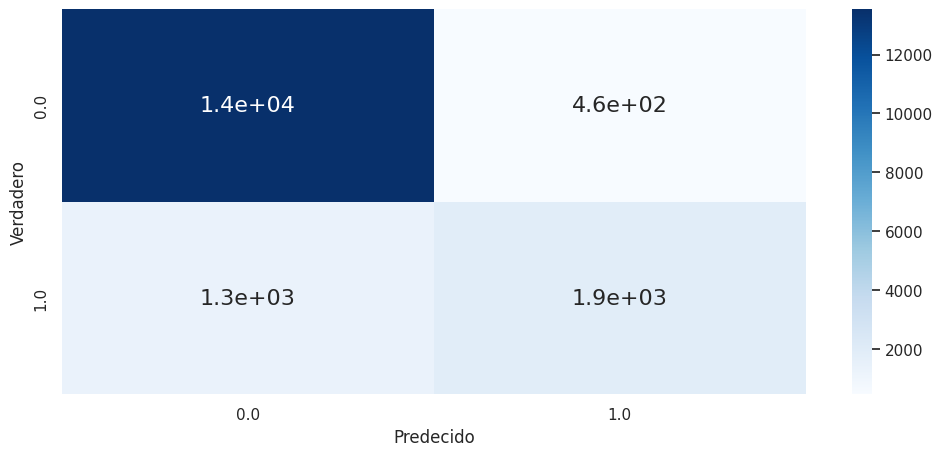

In [ ]:
final_model = GradientBoostingClassifier(max_depth= 5, n_estimators= 180)
final_trained_model = evaluate_test(df_train, df_test, final_model)


              precision    recall  f1-score   support

         0.0       0.98      0.81      0.88     13997
         1.0       0.52      0.92      0.67      3231

    accuracy                           0.83     17228
   macro avg       0.75      0.86      0.77     17228
weighted avg       0.89      0.83      0.84     17228



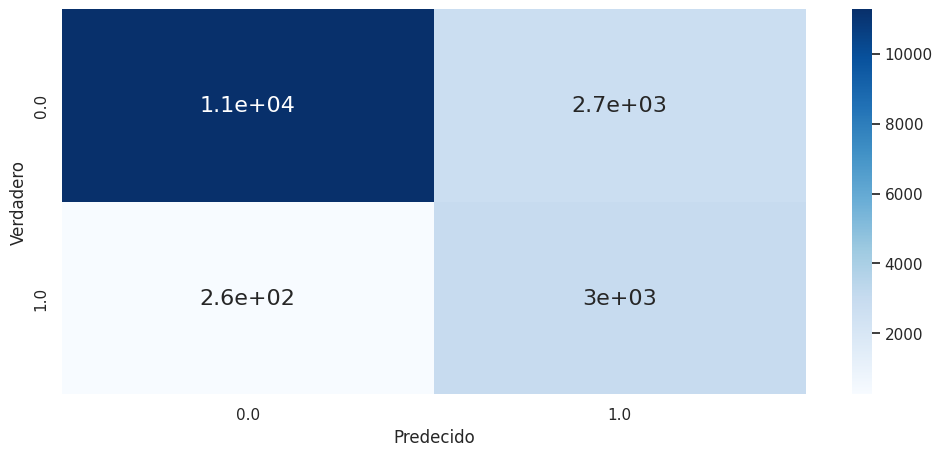

In [ ]:
final_model_sub = GradientBoostingClassifier(max_depth=5, n_estimators=180)
final_trained_model_sub = evaluate_test(df_train_sub, df_test, final_model_sub)


              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     13997
         1.0       0.54      0.90      0.67      3231

    accuracy                           0.84     17228
   macro avg       0.76      0.86      0.78     17228
weighted avg       0.89      0.84      0.85     17228



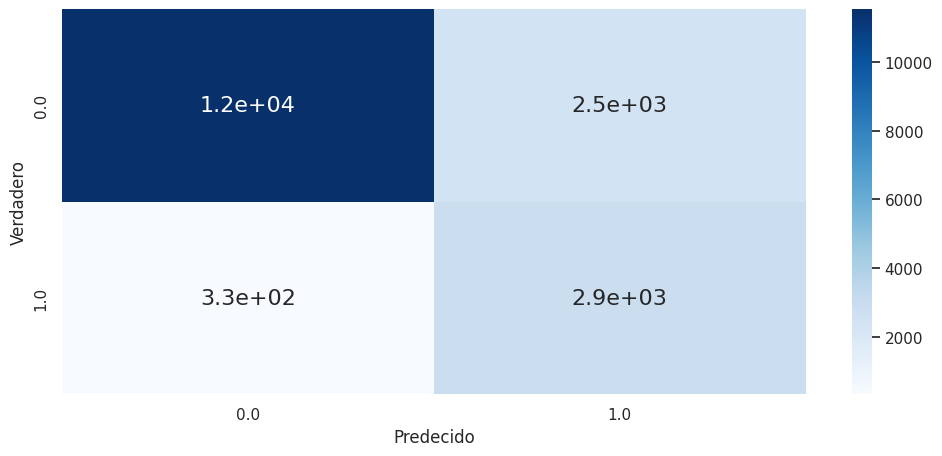

In [ ]:
final_model_over = GradientBoostingClassifier(max_depth=5, n_estimators=180)
final_trained_model_over = evaluate_test(df_train_over, df_test, final_model_over)


### Feature Importance

Solo para modelos de arboles!

In [ ]:
print(final_trained_model.feature_importances_)
feat_importances = pd.Series(
    final_trained_model.feature_importances_, index=df_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[3.90158007e-02 3.05109663e-01 7.46089689e-02 4.55467287e-03
 5.81277560e-03 1.40469920e-03 3.15368039e-03 1.39134521e-03
 3.54596821e-03 5.19514957e-01 1.57322102e-02 4.19914470e-03
 3.84042950e-03 4.13128149e-03 5.31770216e-03 2.12887708e-03
 9.15954198e-04 2.16934485e-03 2.55872948e-04 1.16839640e-03
 1.09463133e-03 1.83295479e-04 1.20861085e-04 1.65663134e-05
 6.89889769e-05 5.43911842e-04]


ValueError: Length of values (26) does not match length of index (27)

In [ ]:
feat_importances

loan_amnt                              0.035549
term                                   0.112332
int_rate                               0.070246
annual_inc                             0.007685
dti                                    0.009907
earliest_cr_line                       0.002670
fico_range_low                         0.004173
open_acc                               0.001993
revol_util                             0.004114
last_pymnt_amnt                        0.704168
acc_open_past_24mths                   0.012039
avg_cur_bal                            0.008006
bc_open_to_buy                         0.005093
bc_util                                0.005725
mo_sin_old_rev_tl_op                   0.005563
mo_sin_rcnt_rev_tl_op                  0.004326
mort_acc                               0.001263
num_actv_rev_tl                        0.002144
home_ownership_RENT                    0.001264
verification_status_Source Verified    0.000364
verification_status_Verified           0